# Project: Linear Regression on King's County Home Sales Data Set

My goal of this project is to determine which features of the data set most influence the price of a home from two perspectives:
- the buyer
- the seller

Sub-goals or questions I will attempt to answer at the tail-end of this work include:
1. Do structural features or location, as a whole, influence home sale price more?

## Approach

My high-level approach is to build the most robust, most predictive model - *that is, with highest *Coefficient of Determination*, $R^2$, that still accurately predicts our target, **price**, with minimized residuals* -  on the largest set of statistically significant features (those with low *p-value*) as possible.

To that end, I adopt standard *model validation* techniques, with some added caveats.

### High $R^2$ is not enough!
We are not only interested simply in the the model's *Coefficient of Determination*, $R^2$, but we also want a feel  of the confidence of that measure.

**A "respectable" $R^2$ (say, $R^2 \ge 0.6$) could be artificially inflated with a high degree of *multicolinearity*, for example**.

### Overfitting must be minimized
As part of our procedure when building linear regression models, we minimize over-fitting with the use of cross-validation and combinatorics.  See *Model Validation* below.

### Data Bias must be minimized as much as possible
I employ the standard *hold-out* set technique to separate data when building models into the usual $0.70$/$0.30$ split of *training* data and *testing* data sets.  Models are built using training data.  Residuals are minimized by targeting models with the minimal Mean Squared Error (MSE) and minimal $\Delta MSE$ between the *predicted* target (**price**) values from the *training* data set vs. the actual target values from the hold-out *testing* data set.

### Model validation, Multicolinearity, and Feature Selection
Confidence in the computed *Coefficient of Determination*, $R^2$, itself must be "measured" since not all $R^2$'s that are equal are created actually "equally" *given the possibility for colinearity* as well as "over-fitness"!

In order to produce a model in which we can be confident in $R^2$, I validate it deterministically.

As will be shown, since we start with 19 predictors (excluding **date** of sale), multicolinearity is a problem.  When multicolinearity is present in a model, we cannot be necessarily in the statistical significance (*p-value*) of a colinear predictor.  So, colinear predictors must be identified and dealt with in order to reduce multicolinearity and thereby provide confidence in the measure of $R^2$ and stastical signficance, in general.

There are two means of handling colinearity of predictors:
1. Introduce an *interaction term*, which will effectively combine two colinear predictors in the model, or
2. Drop a term from a given set of colinear predictors.

Either approach taken must be backed by mathematical rationale.  That is, some mathematically deterministic method must be employed to first *select* (identify) which features are colinear.

#### Variance Inflation Factor
According to James, Witten, Hastie & Tibshirani,

    a better way to assess multi-collinearity is to compute the variance inﬂation factor (VIF). The VIF is the ratio of the variance of [the coefficient of a predictor] when ﬁtting the full model divided by the variance of [the coefficient of a predictor] if ﬁt on its own. The smallest possible value for VIF is 1, which indicates the complete absence of collinearity. Typically in practice there is a small amount of collinearity among the predictors. As a rule of thumb, a VIF value that exceeds 5 or 10 indicates a problematic amount of collinearity.  (James, Witten, Hastie & Tibshirani, 2012)

#### Forward Selection of Features
Rather than making "educated guesses" in the feature selection process, after cleaning the data set, I use *cross-validation*, *k-folds*, and *combinatorics* to select the "best" model (from the best feature-set combination) built on training data when compared to testing data, based a simple, ***greedy* forward selection**. 

The details and pseudocode for the algorithm are listed in the [Cross-Validation Forward Selection of Features](Appendix.ipynb) in the appendix.  

So, some effort is made up front to "intelligently" reduce the set of starting features by building a preliminary model and then removing features which obviously do not inluence **price** or are highly correlated, based on Regression Diagnostics as well as the *Variance Inflation Factor* (VIF) of a given feature.


### Conditions for success - i.e. whether a linear regression model is "good" or "bad"
Given the following conditions, we have a "GOOD" model:
1. $R^2 > .60$
2. $|MSE(test) - MSE(train)| \approx 0$
3. $\frac{|\{feature \in \{selected features\}: VIF(feature) \le 10\}|}{|\{selected features\}|} > .50$ 

The first condition says that we want models that determine the target with 70% confidence.

The second condition says that the bias toward the data is virtuall non-existent.

The third condition says that less than 25% of our selected features are considered *colinear*, by virtue of the propertion of features with *Variance Inflation Factor $(VIF) > 10$*.

### Toward Regression: Most important aspect is understanding the data!
To that end, I proceed according to the following steps:
1. Import all necessary libraries and the the data set
2. Cleaning the data set:
    1. Clean null values, if any
    2. Clean outlier values, if any
    3. Convert feature data types as necessary
3. EDA: Gain familiarity with the data set by building a preliminary linear regression model
    1. Explore distriubutions
    2. Explore colinearity
3. EDA: Scale, Normalize, Transform features in the data set as necessary
4. Run linear regression experiments to derive answers to the following questions:
    1. As a whole, do structural features or location influence home sale price more?
    2. If structural, which subset of features are the most influential?

## Step 1: Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import numpy as np
import scjpnlib.utils as scjpnutils
import scjpnlib.regression.api as scjpnregression
import datetime

%matplotlib inline

plt.style.use('ggplot')

scjpnregression.plot_edge = 4

<br><br>
## Step 2: Exploratory Data Analysis and Data Set Cleaning

In order to focus on building linear regression models in this notebook, Step 2 is done in a separately.

Open [this](Step2.ipynb) notebook to view/re-run [Step 2](Step2.ipynb), though it is not necessary if you want to jump straight into linear regression.

Note that **if you do re-run the [Step 2](Step2.ipynb) notebook, you will have to re-run THIS notebook in order to use those results**.

<br><br>
### Import the cleaned data set

In [2]:
# import the data set
kchd_cleaned_df = pd.read_csv('kc_house_cleaned_data.csv')

target = 'price'

<br><br>
We note that neither **id** nor **date** are useful in this project since it is obvious that neither one should factor into determing our target variablem **price**:
1. **id** will not contribute whatsoever to linear regression
2. if **date** DOES contribute it will likely be due to other factors outside of this data set - e.g. the stock market, the local economy, unemployment rates, etc; so we just drop it from the start to remove any external influence from our model

We will drop those two columns inline whenever we build a linear regression model.

<br><br>
From the Step 2 notebook, we noted that, based on feature definitions provided for this project, we have the following *initial* list of *categorica*l features.

In [3]:
categorical_features = ['waterfront', 'view', 'zipcode']
continuous_features = scjpnutils.get_remaining_features(kchd_cleaned_df, target, categorical_features)
kchd_cat_classification_df = scjpnutils.classify_as_categorical(kchd_cleaned_df, p_cat_th=0.0, exclude_null_vals=False)

<br><br>
## Step 3: Getting to Know the Features and Data: Preliminary Linear Regression Model

We now want to get a feel for how the feature set performs in a linear regression model *without scaling, normalization, or log-transformation of the data*.

The `lin_reg_model` function accomplishes this for us.  It wraps up a few tasks on our behalf, the most important of which is actually building the model using statsmodels Ordinary Least Squares (OLS) method.  But first, it uses the `cv_score` function to split the data set into test and training paritions at a ratio of 70/30%, which is industry standard.  The model is built, of course, on the training partition and then validated against the data in the test partition.

A *feature-selector* function can ***optionally*** be passed into this function in order to "auto-select" whether a feature is included in the model or not.  If a *feature-selector* function is used, feature-selection is done prior to building the model.

There are two feature-selector functions available:
1. **[stepwise-selection](https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-forward-selection-stepwise-regression-algorithm)**: authored by authored by David Dale; this feature-selector method includes a feature in (or drops from) the model based on its *p_value*.
2. **cv_selection**: this feature-selector method, authored by me, selects features using an EXHAUSTIVE search for the best model/feature-set which optimizes selection based on minimal $RMSE$ and $\Delta RMSE$, as well as minimized multicolinearity.  Please feel free to review its details in [Cross-Validation Forward Selection of Features](Appendix.ipynb) in the Appendix.

For the initial model, since we are doing this to get a feel for how the data performs in linear regression, we will conduct no feature auto-selection at this time.


formula: price~bedrooms+bathrooms+sqft_living+sqft_lot+floors+waterfront+view+condition+grade+sqft_above+sqft_basement+yr_built+yr_renovated+zipcode+lat+long+sqft_living15+sqft_lot15


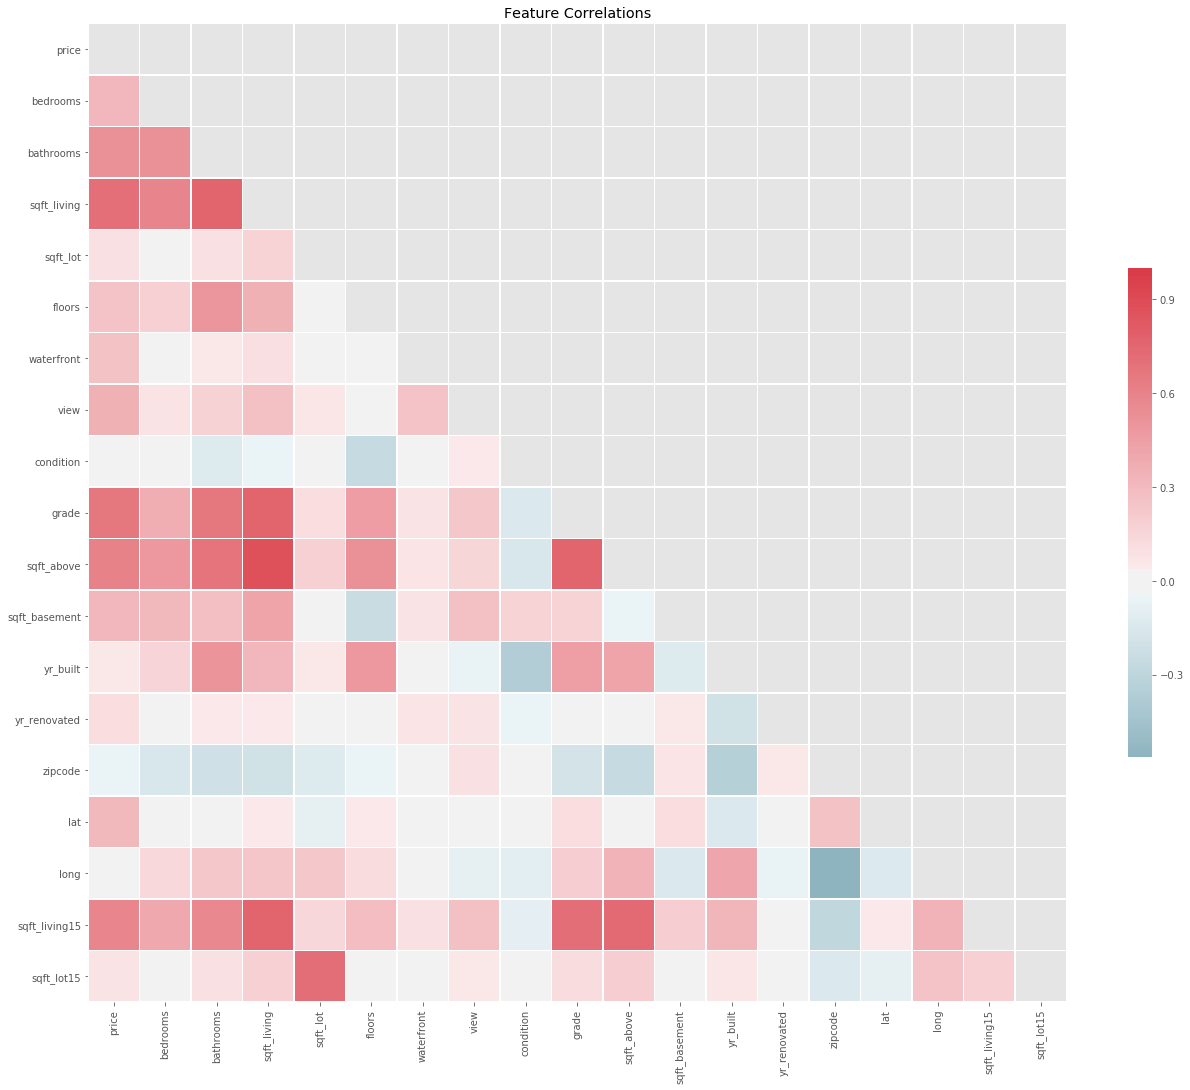

C:\Users\tripp\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


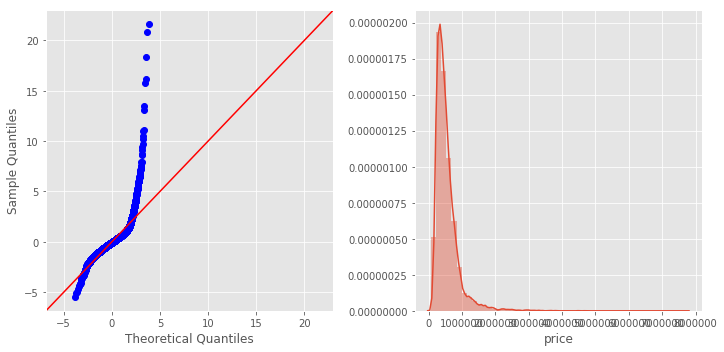

In [4]:
target = 'price'
mv_r_sq_th = .50  # i.e. we want more than 50% Coefficient of Determination
mv_delta_score_th = 1 # default scoring method is delta RMSE
mv_bad_vif_ratio_th = 0.50

(
    sel_features
    , X_train
    , X_test
    , y_train
    , y_test
    , train_score
    , test_score
    , model
) = scjpnregression.lin_reg_model(
    kchd_cleaned_df.drop(['id', 'date'], axis=1)
    , target
    , title="Preliminary Linear Regression Model:"
)

(model_fit_results, good_vif_features, bad_vif_features) = scjpnregression.model_fit_summary(
    kchd_cleaned_df
    , sel_features
    , target
    , model
    , train_score
    , test_score
    , mv_r_sq_th
    , mv_delta_score_th
    , mv_bad_vif_ratio_th
)

<br><br>
### Preliminary Linear Regression Model: Analysis

In [5]:
display(HTML("$R^2 = {}$ is pretty good! But model validation fails Model Validation.".format(round(model_fit_results.rsquared, 3))))
display(HTML("Take a look at the difference in RMSEs of the residuals between the train/test data (using the standard 70/30% split ratio)."))
display(HTML("<b>$\\Delta RMSE$ is a woeful ${}$</b>!".format(int(abs(train_score-test_score)))))

Note, in particular, that OLS reports that **"there are
strong multicollinearity or other numerical problems"** in the data set.

Our VIF summary states in more detail that most of our features are colinear.

$\Delta RMSE$ is not good.  The meaning is that **this model does not reliably/accurately predict our target, *price*, in our test data set**.

The QQ-plot of residuals is UGLY!  It indicates an abundance of outliers by virtue of SEVERE tail deviation.

According to the [kurtosis](https://www.investopedia.com/terms/k/kurtosis.asp) article, kurtosis of this sort is [**leptokurtic**](https://www.investopedia.com/terms/l/leptokurtic.asp) and is highly undesirable since **there are occasional extreme outliers that cause 'concentrations' of observations** and detracts from stable predictability.  A leptokurtic distribution means that the **we can experience broader fluctuations in our target (e.g. three or more standard deviations from the mean) resulting in greater potential for extremely low or high price**. ("Kurtosis" and "Understanding Leptokurtic Distributions", 2019).

<br><br>
#### CONCLUSION:

**This is not a well-performing model**.  Not at all.

We MUST do some work to improve the performance of our preliminary linear regression model if we hope to predict sale price with confidence. 

#### What can we do to improve its performance?

The first thing we notice in the QQ-plot and the distribution plot of our target, **price**, is that it is heavily skewed - i.e. NOT normally distributed.

Before we consider possibly dropping any features due to misbehavior, we shall scale and possibly transform our data set as a first measure.

But before we get into that, let's **give out target, *price*, a normal distribution by *log-transforming* it**.  And of course we will re-run regression to investigate the impact.  We noted already that the QQ-plot of residuals indicates the presence of outliers.  Scaling our target may mitigate this.

C:\Users\tripp\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


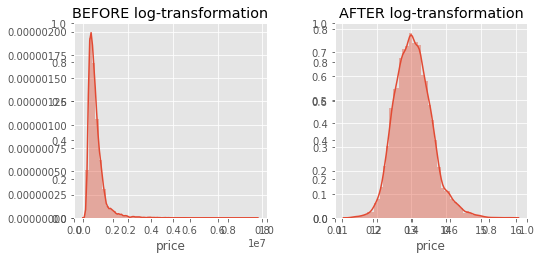

In [6]:
kchd_cleaned_with_log_transformed_target_df = kchd_cleaned_df.copy()
kchd_cleaned_with_log_transformed_target_df[target] = kchd_cleaned_with_log_transformed_target_df[target].map(lambda v: np.log(v))

scjpnregression.histograms_comparison(
    kchd_cleaned_df[[target]]
    , kchd_cleaned_with_log_transformed_target_df[[target]]
    , "BEFORE log-transformation"
    , "AFTER log-transformation"
)

<br><br>
### Preliminary Linear Regression Model: after *log-transforming* our target, *price*

Building a newly built linear regression model based on log-transformed target, **price**, in theory, should perform better than the last one.


formula: price~bedrooms+bathrooms+sqft_living+sqft_lot+floors+waterfront+view+condition+grade+sqft_above+sqft_basement+yr_built+yr_renovated+zipcode+lat+long+sqft_living15+sqft_lot15


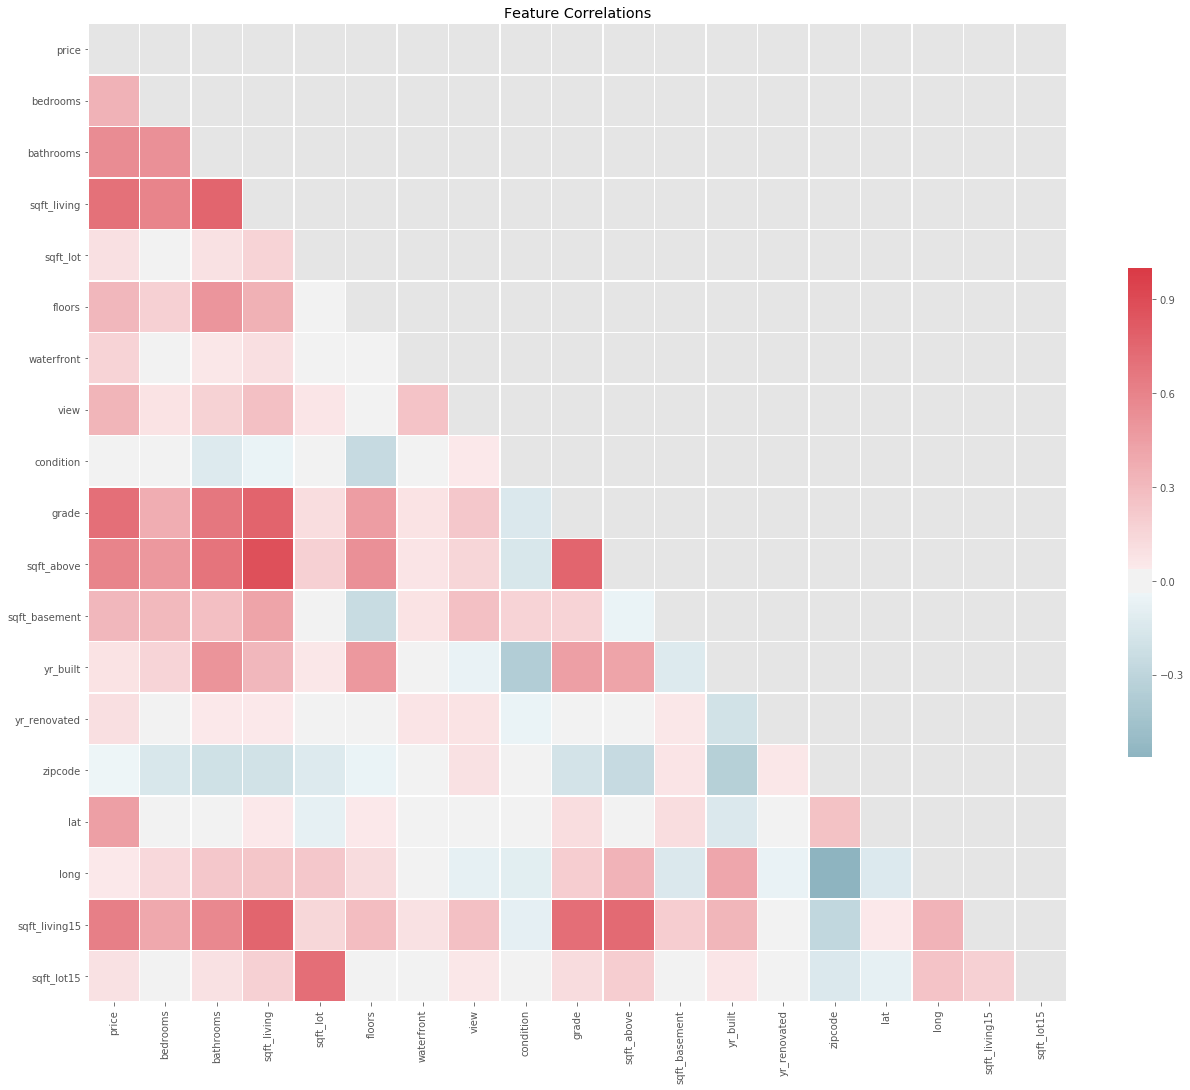

C:\Users\tripp\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


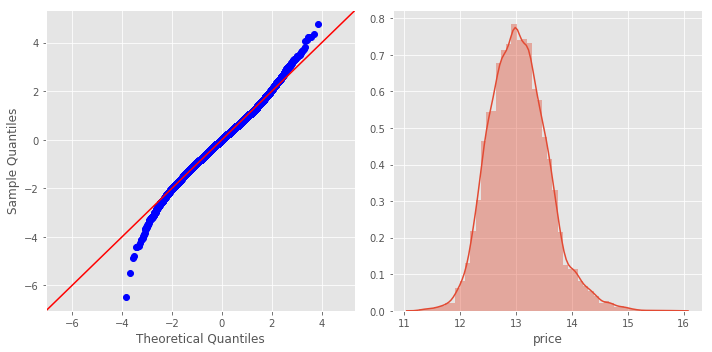

In [7]:
(
    preliminary_model_features
    , X_train
    , X_test
    , y_train
    , y_test
    , train_score
    , test_score
    , model
) = scjpnregression.lin_reg_model(
    kchd_cleaned_with_log_transformed_target_df.drop(['id', 'date'], axis=1)
    , target
    , title="Preliminary Linear Regression Model, after <i>log-transforming</i> target, <i>price</i>"
)

(model_fit_results, good_vif_features, bad_vif_features) = scjpnregression.model_fit_summary(
    kchd_cleaned_with_log_transformed_target_df.drop(['id', 'date'], axis=1)
    , preliminary_model_features
    , target
    , model
    , train_score
    , test_score
    , mv_r_sq_th
    , mv_delta_score_th
    , mv_bad_vif_ratio_th
)

<br><br>
### Preliminary Linear Regression Model, after log-transforming target, *price*: ANALYSIS

In [8]:
display(HTML("$R^2 = {}$ has improved quite a bit!".format(round(model_fit_results.rsquared, 3))))
display(HTML("<b>Perhaps more impressive is the drop in $\Delta RMSE$ to approximately ${}$</b>!".format(int(abs(train_score-test_score)))))
display(HTML("The <i>Condition Number</i> is super high, indicating multicolinearity is still an issue with {}% of our features being colinear (according to VIF analysis).".format(round((len(bad_vif_features)/len(sel_features))*100,2))))

Looking at the QQ-plot of residuals, the problem with outliers has improved (but not much) by *log-transforming* our target, **price**.

The kurtosis manifested in this model appears to be a blend of [**leptokurtic**](https://www.investopedia.com/terms/l/leptokurtic.asp) and [**platykurtic**](https://www.investopedia.com/terms/p/platykurtic.asp) kurtosis.  

According to the [kurtosis](https://www.investopedia.com/terms/k/kurtosis.asp) article, **models manifesting [mesokurtic](https://www.investopedia.com/terms/m/mesokurtic.asp) distributions in the target are the most desirable since they will most stably offer accurate predictions**.  

A model exhibiting a platykurtic distribution in the target is reliable (but not as much as one with  mesokurtic kurtosis) since, according to the article, **platykurtic target distributions are stable and predictable, in the sense that there will rarely (if ever) be extreme (outlier) observations of the target**.

As mentioned previously, leptokurtic distributions in the target are highly undesirable since there are occasional extreme outliers that cause 'concentrations' of observations and detract from stable predictability because we can experience broader fluctuations in our target (e.g. three or more standard deviations from the mean) resulting in greater potential for extremely low or high. ("Kurtosis" and "Understanding Leptokurtic Distributions", 2019).

We want a model with a kurtosis that is clearly platykurtic (acceptable) or mesokurtic (best case).

The most important takeaway here is the plot of residuals.  Our predictive "power" with this model has improved a lot.

<br><br>
#### CONCLUSION:
Model Validation appears to have passed.  We have VASTLY improved our model, just by *log-transforming* our target feature, **price**.

Nevertheless, since this model still exhibits kurtosis that somewhat leptokurtic, we reject it.

#### What can we do to improve its performance?
Again, before we consider dropping features as a means to deal with multicolinearity, let's check for abnormal distributions of our features and log-transform them as necessary.  We will also *min-max scale* our target as well as all of our *continuous* features.  We will eventually get to the point where we officially *categorize* our *categorical* variables.  Doing all of this will eventually bring the ranges of our target and features (*continuous* and *categorical*) to \[0, 1\], which should improve our model even more.  Doing this should, in theory, address outliers even more.

Let's have a look at the regression diagnostic and distribution plots of our predictors from the last model and use them as a basis to further out understanding of our features.

<br><br>
### Feature understanding and Fine Tuning

Here, we leverage Regression Diagnostics of the **Preliminary Linear Regression Model, after log-transforming target, *price*** to better understand how we can tune our data for a better performing model.

We'll examine features one by one within the context of Regression Diagnostics from the last model we built.

C:\Users\tripp\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


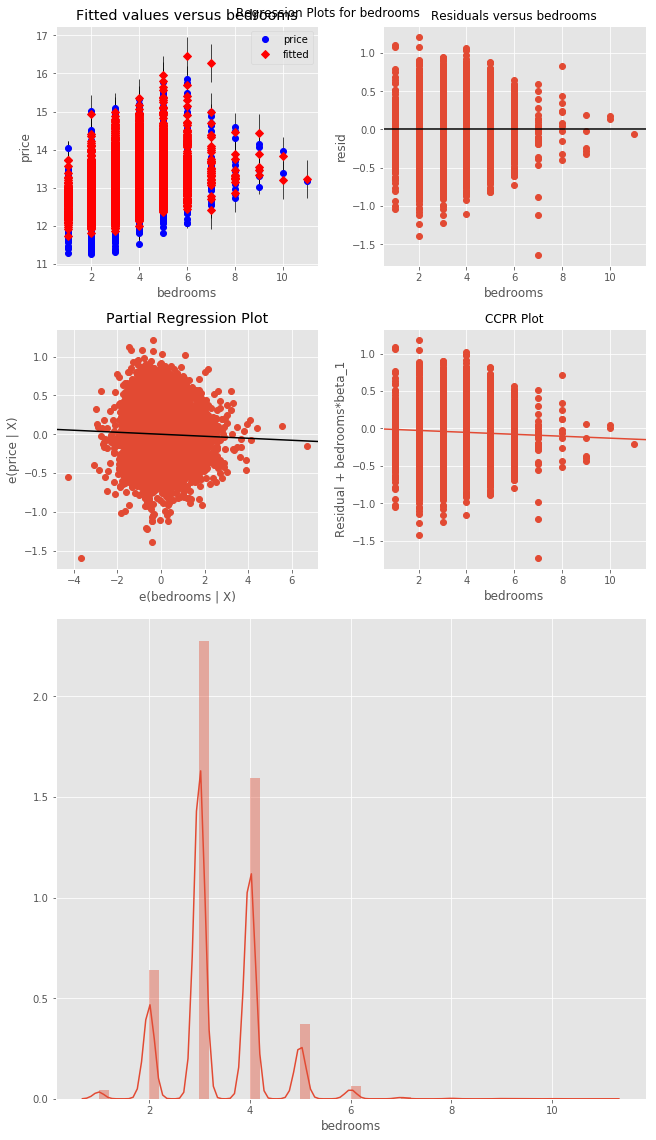

In [9]:
continuous_features = []
categorical_features = []
cont_feats_to_be_logtransformed = []

kchd_cleaned_and_transformed_df = kchd_cleaned_with_log_transformed_target_df.copy()

curr_feat_idx = 0

if curr_feat_idx < len(preliminary_model_features):
    scjpnregression.feature_regression_summary(
        kchd_cleaned_with_log_transformed_target_df[preliminary_model_features]
        , curr_feat_idx
        , target
        , model_fit_results
        , display_regress_diagnostics=True
    )

1. p-value is low but VIF is high indicating colinearity, therefore this p-value should not be trusted
2. appears to be *categorical*
    1. We will add it to our list of known *categorical* features and then set it aside for now.
    2. We will deal with it with all *categorical* features later as a whole.

In [10]:
categorical_features.append('bedrooms')
continuous_features = scjpnutils.get_remaining_features(kchd_cleaned_df.drop(['id', 'date'], axis=1), target, categorical_features)

C:\Users\tripp\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


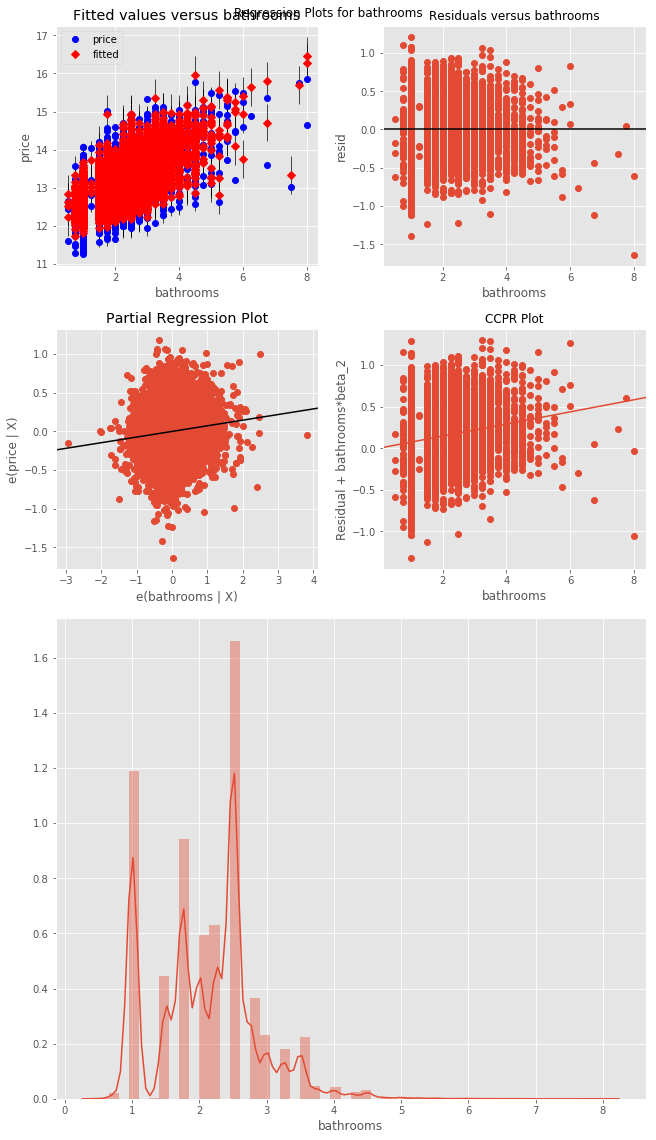

In [11]:
curr_feat_idx += 1

if curr_feat_idx < len(preliminary_model_features):
    scjpnregression.feature_regression_summary(
        kchd_cleaned_with_log_transformed_target_df[preliminary_model_features]
        , curr_feat_idx
        , target
        , model_fit_results
        , display_regress_diagnostics=True
    )

1. p-value is low but VIF is high indicating colinearity, therefore this p-value should not be trusted
2. appears to be *categorical*
    1. We will add it to our list of known *categorical* features and then set it aside for now.
    2. We will deal with it with all *categorical* features later as a whole.

In [12]:
categorical_features.append('bathrooms')
continuous_features = scjpnutils.get_remaining_features(kchd_cleaned_df.drop(['id', 'date'], axis=1), target, categorical_features)

C:\Users\tripp\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


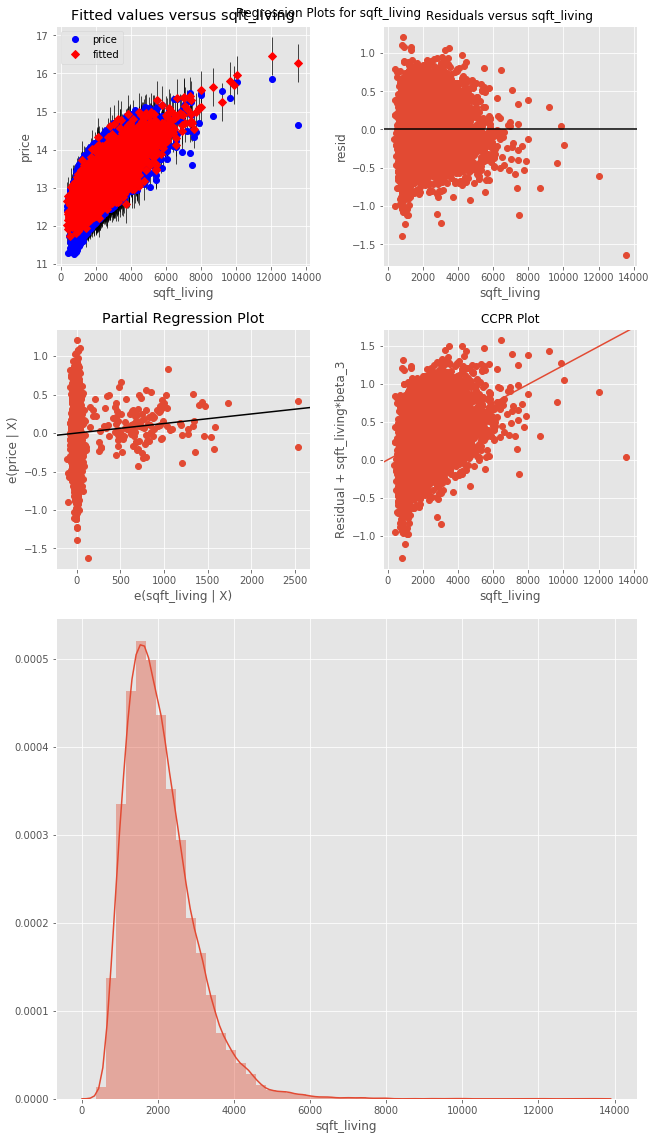

In [13]:
curr_feat_idx += 1

if curr_feat_idx < len(preliminary_model_features):
    scjpnregression.feature_regression_summary(
        kchd_cleaned_with_log_transformed_target_df[preliminary_model_features]
        , curr_feat_idx
        , target
        , model_fit_results
        , display_regress_diagnostics=True
    )

1. p-value is low but VIF is high indicating colinearity, therefore this p-value should not be trusted
2. appears to be *continuous*
    1. distribution is skewed to the left
    2. needs to be *log-transformed* in order to push its distriubution more towards normal

In [14]:
cont_feats_to_be_logtransformed.append('sqft_living')

C:\Users\tripp\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


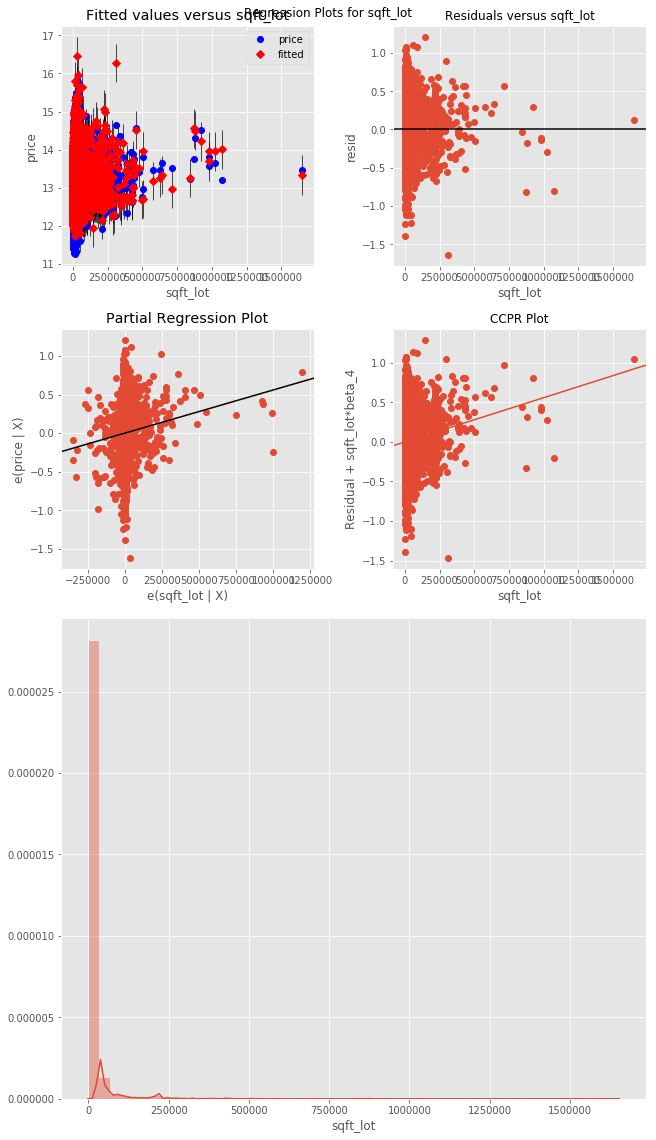

In [15]:
curr_feat_idx += 1

if curr_feat_idx < len(preliminary_model_features):
    scjpnregression.feature_regression_summary(
        kchd_cleaned_with_log_transformed_target_df[preliminary_model_features]
        , curr_feat_idx
        , target
        , model_fit_results
        , display_regress_diagnostics=True
    )

1. p-value is low and VIF is low, therefore this p-value can be trusted
2. appears to be *continuous*
    1. distribution is skewed to the left
    2. needs to be *log-transformed* in order to push its distriubution more towards normal

In [16]:
cont_feats_to_be_logtransformed.append('sqft_lot')

C:\Users\tripp\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


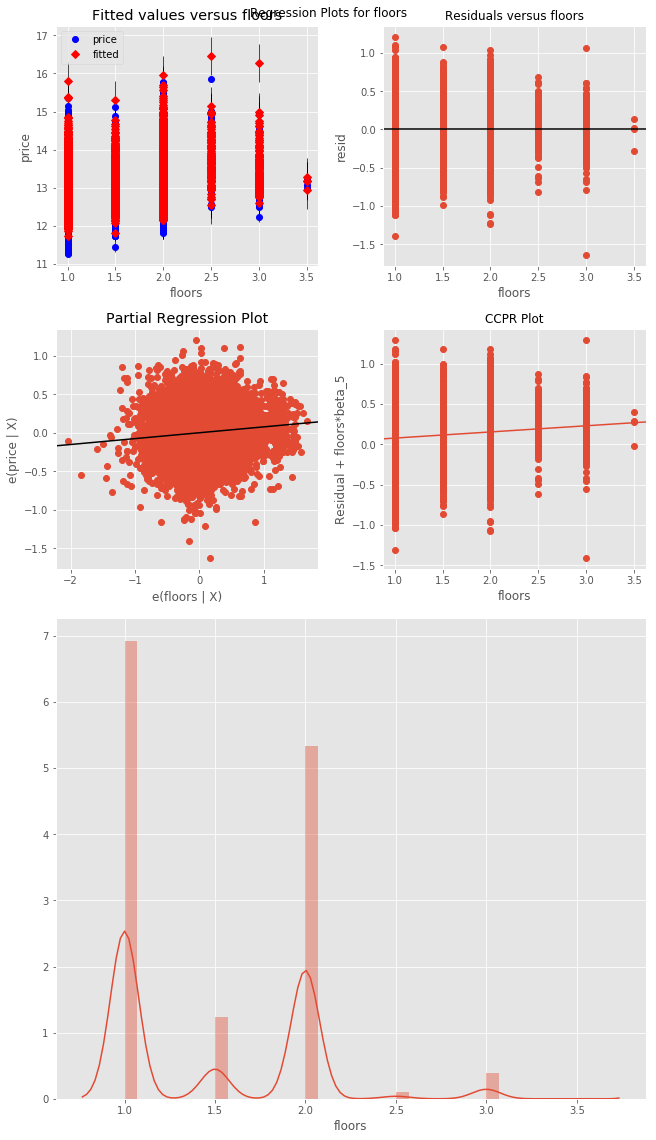

In [17]:
curr_feat_idx += 1

if curr_feat_idx < len(preliminary_model_features):
    scjpnregression.feature_regression_summary(
        kchd_cleaned_with_log_transformed_target_df[preliminary_model_features]
        , curr_feat_idx
        , target
        , model_fit_results
        , display_regress_diagnostics=True
    )

1. p-value is low but VIF is high indicating colinearity, therefore this p-value should not be trusted
2. appears to be *categorical*
    1. We will add it to our list of known *categorical* features and then set it aside for now.
    2. We will deal with it with all *categorical* features later as a whole.

In [18]:
categorical_features.append('floors')
continuous_features = scjpnutils.get_remaining_features(kchd_cleaned_df.drop(['id', 'date'], axis=1), target, categorical_features)

C:\Users\tripp\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


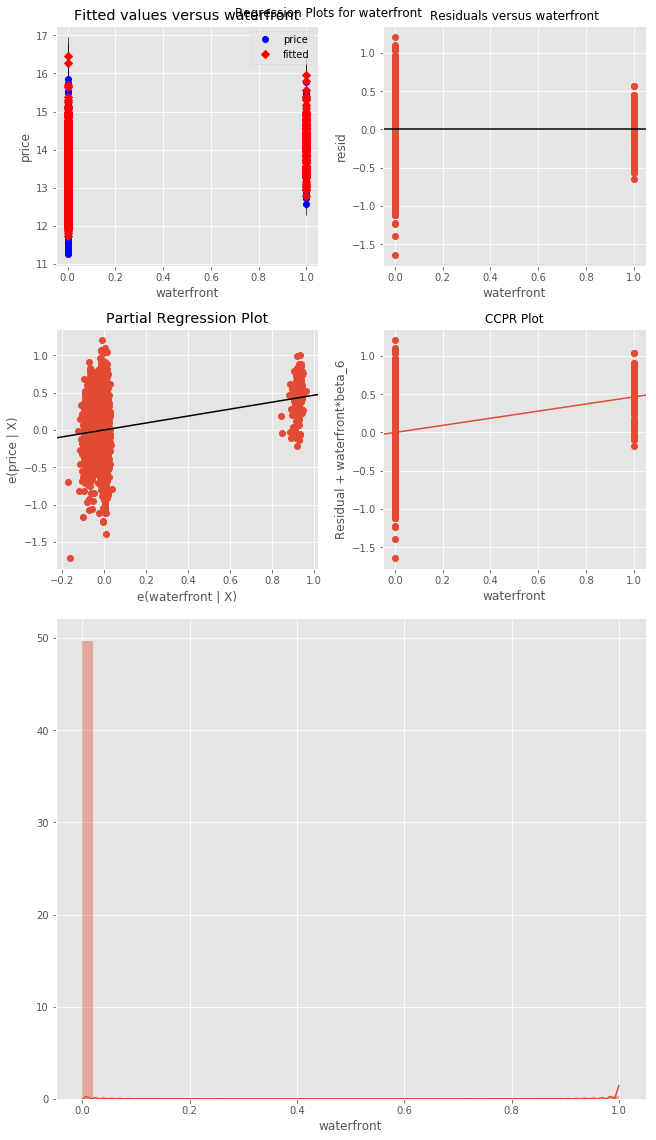

In [19]:
curr_feat_idx += 1

if curr_feat_idx < len(preliminary_model_features):
    scjpnregression.feature_regression_summary(
        kchd_cleaned_with_log_transformed_target_df[preliminary_model_features]
        , curr_feat_idx
        , target
        , model_fit_results
        , display_regress_diagnostics=True
    )

1. p-value is low and VIF is low, therefore this p-value can be trusted
2. appears to be *categorical*
    1. We will add it to our list of known *categorical* features and then set it aside for now.
    2. We will deal with it with all *categorical* features later as a whole.

In [20]:
categorical_features.append('waterfront')
continuous_features = scjpnutils.get_remaining_features(kchd_cleaned_df.drop(['id', 'date'], axis=1), target, categorical_features)

C:\Users\tripp\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


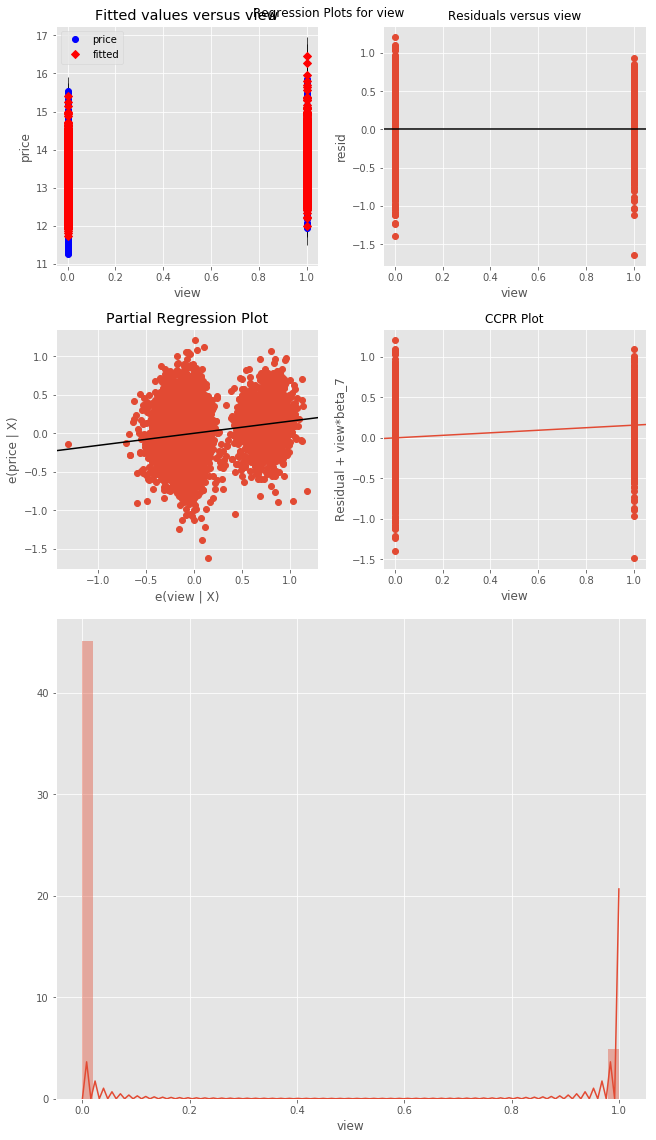

In [21]:
curr_feat_idx += 1

if curr_feat_idx < len(preliminary_model_features):
    scjpnregression.feature_regression_summary(
        kchd_cleaned_with_log_transformed_target_df[preliminary_model_features]
        , curr_feat_idx
        , target
        , model_fit_results
        , display_regress_diagnostics=True
    )

1. p-value is low and VIF is low, therefore this p-value can be trusted
2. appears to be *categorical*
    1. We will add it to our list of known *categorical* features and then set it aside for now.
    2. We will deal with it with all *categorical* features later as a whole.

In [22]:
categorical_features.append('view')
continuous_features = scjpnutils.get_remaining_features(kchd_cleaned_df.drop(['id', 'date'], axis=1), target, categorical_features)

C:\Users\tripp\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


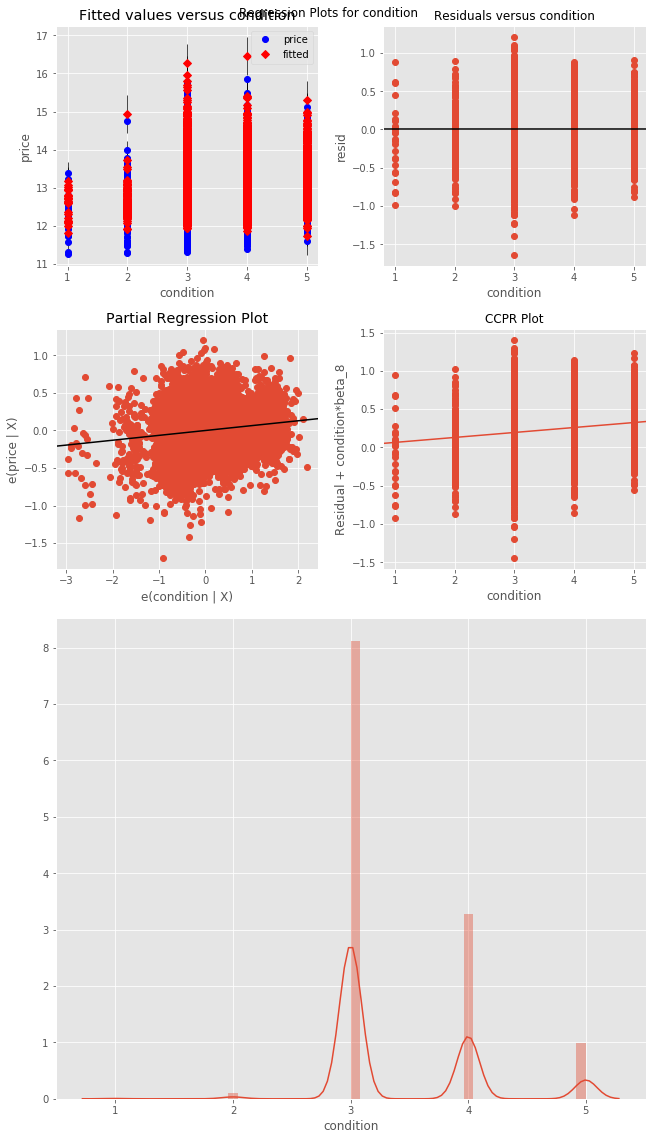

In [23]:
curr_feat_idx += 1

if curr_feat_idx < len(preliminary_model_features):
    scjpnregression.feature_regression_summary(
        kchd_cleaned_with_log_transformed_target_df[preliminary_model_features]
        , curr_feat_idx
        , target
        , model_fit_results
        , display_regress_diagnostics=True
    )

1. p-value is low but VIF is high indicating colinearity, therefore this p-value should not be trusted
2. appears to be *categorical*
    1. We will add it to our list of known *categorical* features and then set it aside for now.
    2. We will deal with it with all *categorical* features later as a whole.

In [24]:
categorical_features.append('condition')
continuous_features = scjpnutils.get_remaining_features(kchd_cleaned_df.drop(['id', 'date'], axis=1), target, categorical_features)

C:\Users\tripp\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


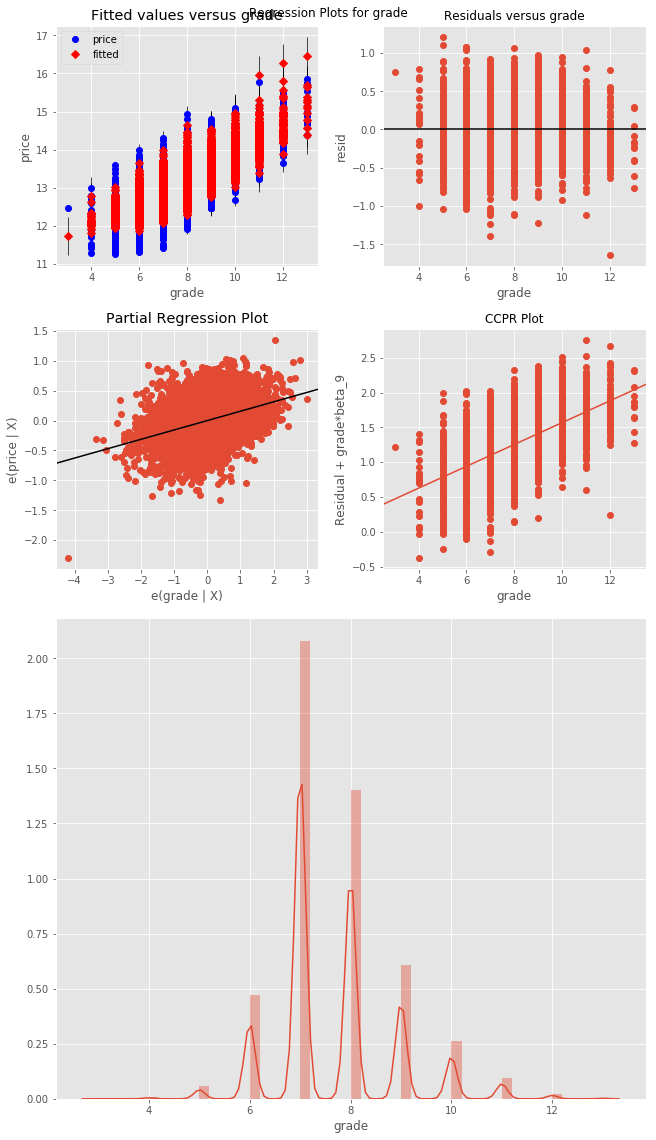

In [25]:
curr_feat_idx += 1

if curr_feat_idx < len(preliminary_model_features):
    scjpnregression.feature_regression_summary(
        kchd_cleaned_with_log_transformed_target_df[preliminary_model_features]
        , curr_feat_idx
        , target
        , model_fit_results
        , display_regress_diagnostics=True
    )

1. p-value is low but VIF is high indicating colinearity, therefore this p-value should not be trusted
2. appears to be *categorical*
    1. We will add it to our list of known *categorical* features and then set it aside for now.
    2. We will deal with it with all *categorical* features later as a whole.

In [26]:
categorical_features.append('grade')
continuous_features = scjpnutils.get_remaining_features(kchd_cleaned_df.drop(['id', 'date'], axis=1), target, categorical_features)

C:\Users\tripp\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


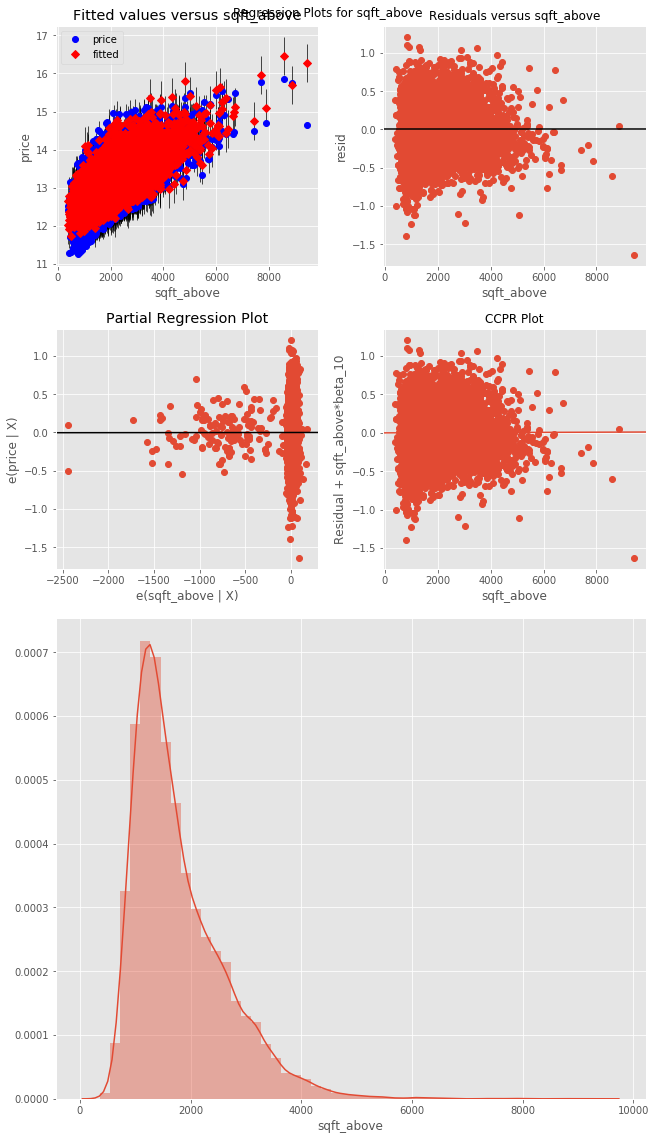

In [27]:
curr_feat_idx += 1

if curr_feat_idx < len(preliminary_model_features):
    scjpnregression.feature_regression_summary(
        kchd_cleaned_with_log_transformed_target_df[preliminary_model_features]
        , curr_feat_idx
        , target
        , model_fit_results
        , display_regress_diagnostics=True
    )

1. p-value is high and VIF is high indicating colinearity, therefore this p-value should not be trusted
2. appears to be *continuous*
    1. distribution is skewed to the left
    2. needs to be *log-transformed* in order to push its distriubution more towards normal

In [28]:
cont_feats_to_be_logtransformed.append('sqft_above')

C:\Users\tripp\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


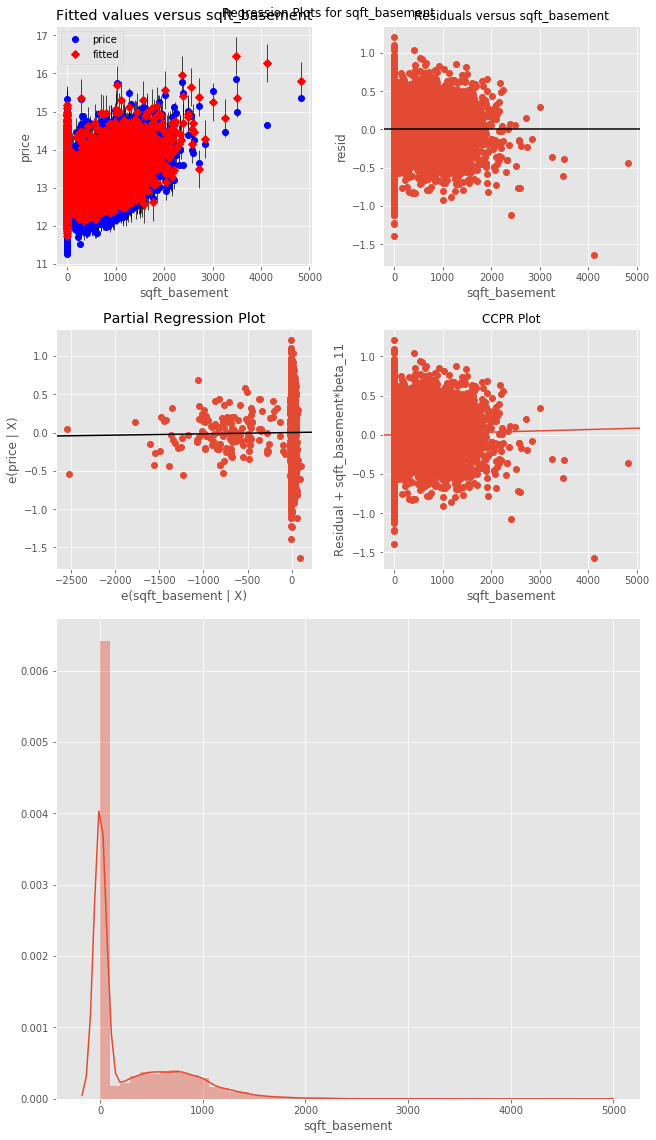

In [29]:
curr_feat_idx += 1

if curr_feat_idx < len(preliminary_model_features):
    scjpnregression.feature_regression_summary(
        kchd_cleaned_with_log_transformed_target_df[preliminary_model_features]
        , curr_feat_idx
        , target
        , model_fit_results
        , display_regress_diagnostics=True
    )

1. p-value is high and VIF is high indicating colinearity, therefore this p-value should not be trusted
2. appears to be *continuous*
    1. distribution is skewed to the left
    2. needs to be *log-transformed* in order to push its distriubution more towards normal

In [30]:
cont_feats_to_be_logtransformed.append('sqft_basement')

C:\Users\tripp\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


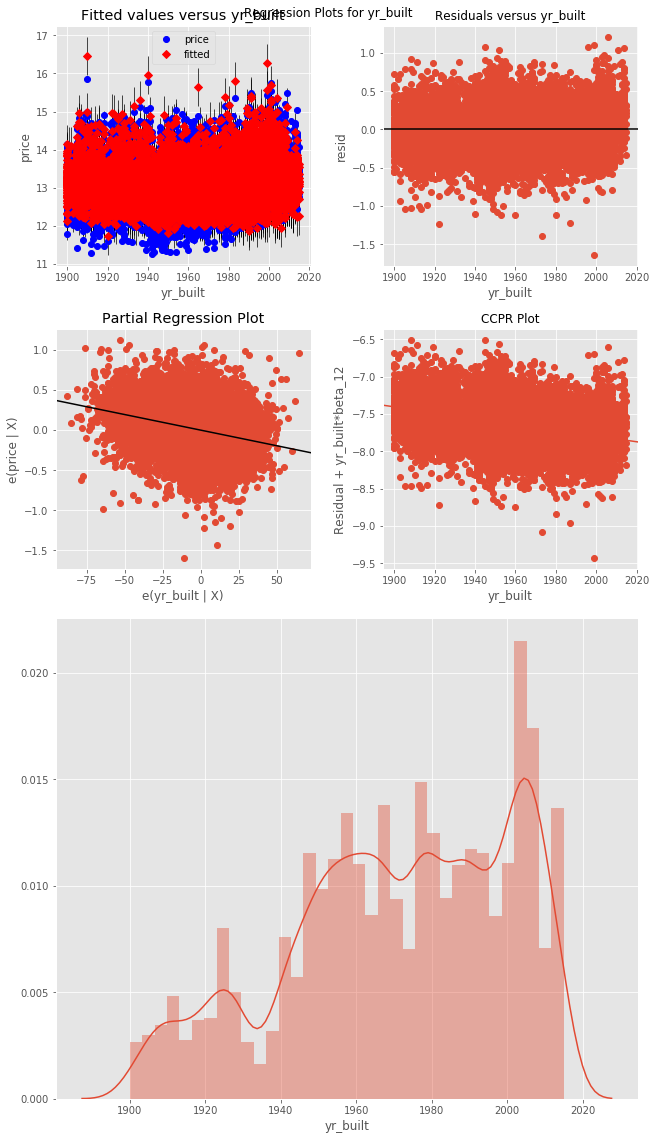

In [31]:
curr_feat_idx += 1

if curr_feat_idx < len(preliminary_model_features):
    scjpnregression.feature_regression_summary(
        kchd_cleaned_with_log_transformed_target_df[preliminary_model_features]
        , curr_feat_idx
        , target
        , model_fit_results
        , display_regress_diagnostics=True
    )

1. p-value is low but VIF is EXTREMELY high indicating colinearity, therefore this p-value should not be trusted
2. appears to be *continuous*
    1. distribution is skewed to the left
    2. needs to be *log-transformed* in order to push its distriubution more towards normal

In [32]:
# categorical_features.append('yr_built')
# continuous_features = scjpnutils.get_remaining_features(kchd_cleaned_df, target, categorical_features)
cont_feats_to_be_logtransformed.append('yr_built')

C:\Users\tripp\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


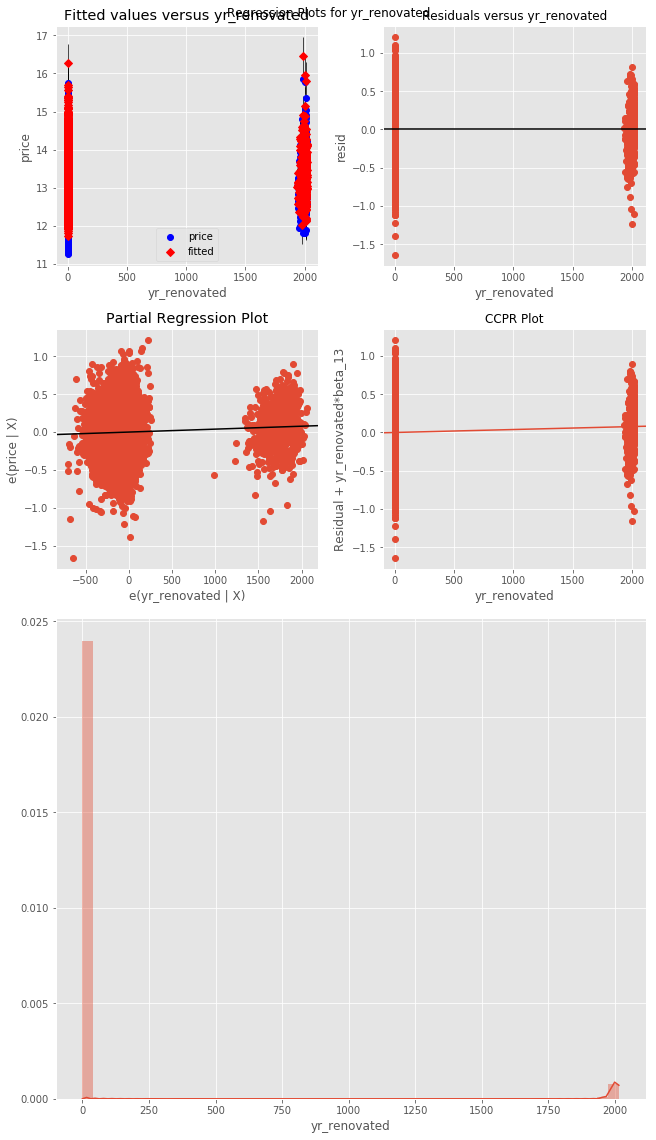

In [33]:
curr_feat_idx += 1

if curr_feat_idx < len(preliminary_model_features):
    scjpnregression.feature_regression_summary(
        kchd_cleaned_with_log_transformed_target_df[preliminary_model_features]
        , curr_feat_idx
        , target
        , model_fit_results
        , display_regress_diagnostics=True
    )

1. p-value is low and VIF is low, therefore this p-value can be trusted
2. appears to be *categorical*
    1. We will add it to our list of known *categorical* features and then set it aside for now.
    2. We will deal with it with all *categorical* features later as a whole.

In [34]:
categorical_features.append('yr_renovated')
continuous_features = scjpnutils.get_remaining_features(kchd_cleaned_df.drop(['id', 'date'], axis=1), target, categorical_features)

C:\Users\tripp\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


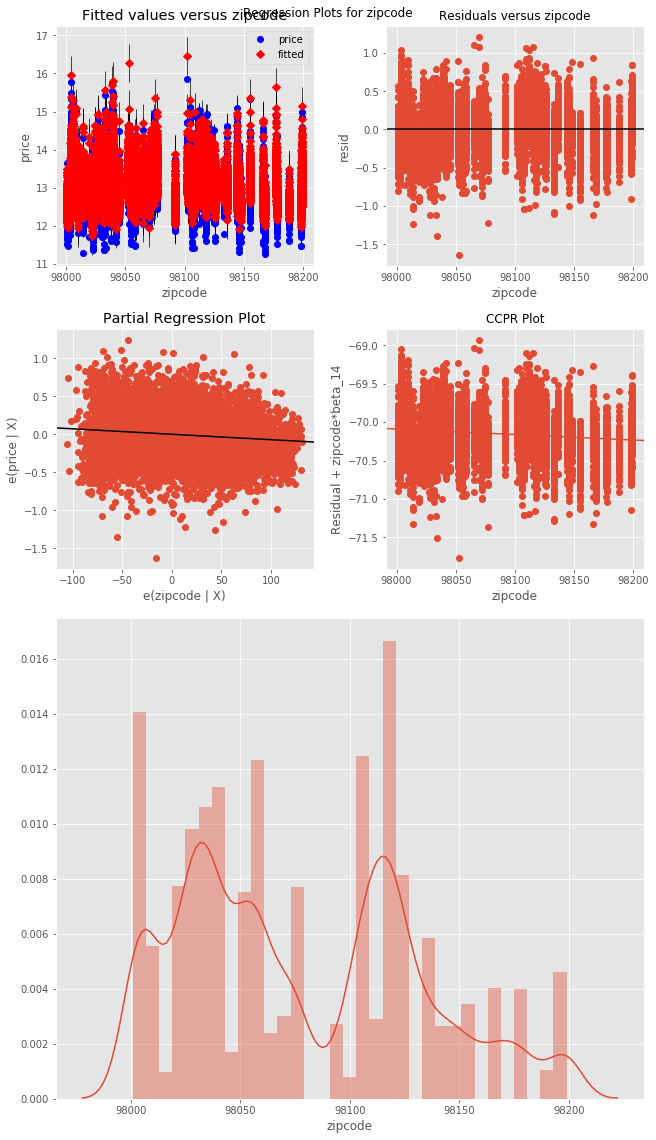

In [35]:
curr_feat_idx += 1

if curr_feat_idx < len(preliminary_model_features):
    scjpnregression.feature_regression_summary(
        kchd_cleaned_with_log_transformed_target_df[preliminary_model_features]
        , curr_feat_idx
        , target
        , model_fit_results
        , display_regress_diagnostics=True
    )

1. p-value is low but VIF is EXTREMELY high indicating colinearity, therefore this p-value should not be trusted
2. appears to be *categorical*
    1. We will add it to our list of known *categorical* features and then set it aside for now.
    2. We will deal with it with all *categorical* features later as a whole.

In [36]:
categorical_features.append('zipcode')
continuous_features = scjpnutils.get_remaining_features(kchd_cleaned_df.drop(['id', 'date'], axis=1), target, categorical_features)

C:\Users\tripp\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


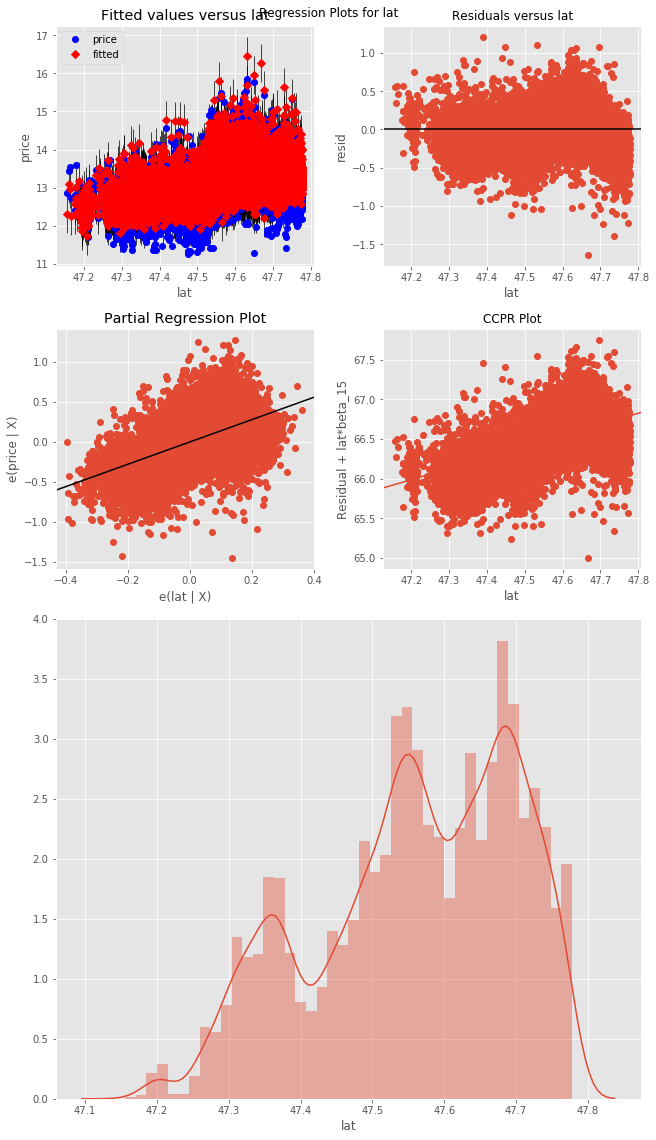

In [37]:
curr_feat_idx += 1

if curr_feat_idx < len(preliminary_model_features):
    scjpnregression.feature_regression_summary(
        kchd_cleaned_with_log_transformed_target_df[preliminary_model_features]
        , curr_feat_idx
        , target
        , model_fit_results
        , display_regress_diagnostics=True
    )

1. p-value is low but VIF is EXTREMELY high indicating colinearity, therefore this p-value should not be trusted
2. appears to be *continuous*
    1. distribution is skewed to the right
    2. needs to be *log-transformed* in order to push its distriubution more towards normal

In [38]:
cont_feats_to_be_logtransformed.append('lat')

C:\Users\tripp\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


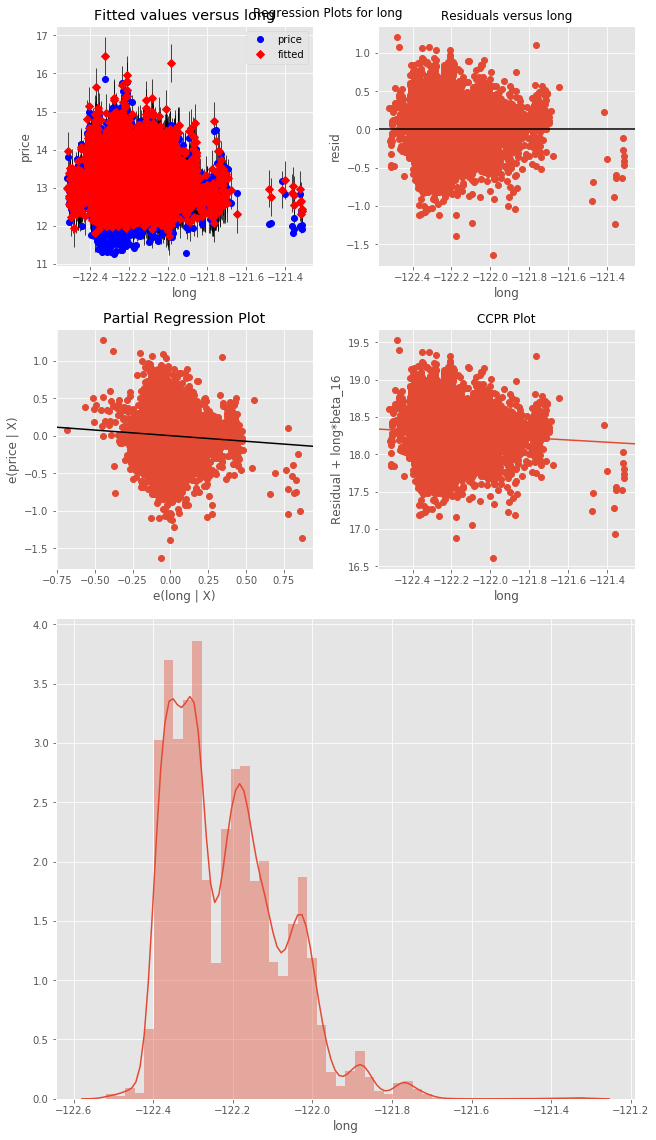

In [39]:
curr_feat_idx += 1

if curr_feat_idx < len(preliminary_model_features):
    scjpnregression.feature_regression_summary(
        kchd_cleaned_with_log_transformed_target_df[preliminary_model_features]
        , curr_feat_idx
        , target
        , model_fit_results
        , display_regress_diagnostics=True
    )

1. p-value is low but VIF is EXTREMELY high indicating colinearity, therefore this p-value should not be trusted
2. appears to be *continuous*
    1. distribution is skewed to the left
    2. needs to be *log-transformed* in order to push its distriubution more towards normal

In [40]:
cont_feats_to_be_logtransformed.append('long')

C:\Users\tripp\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


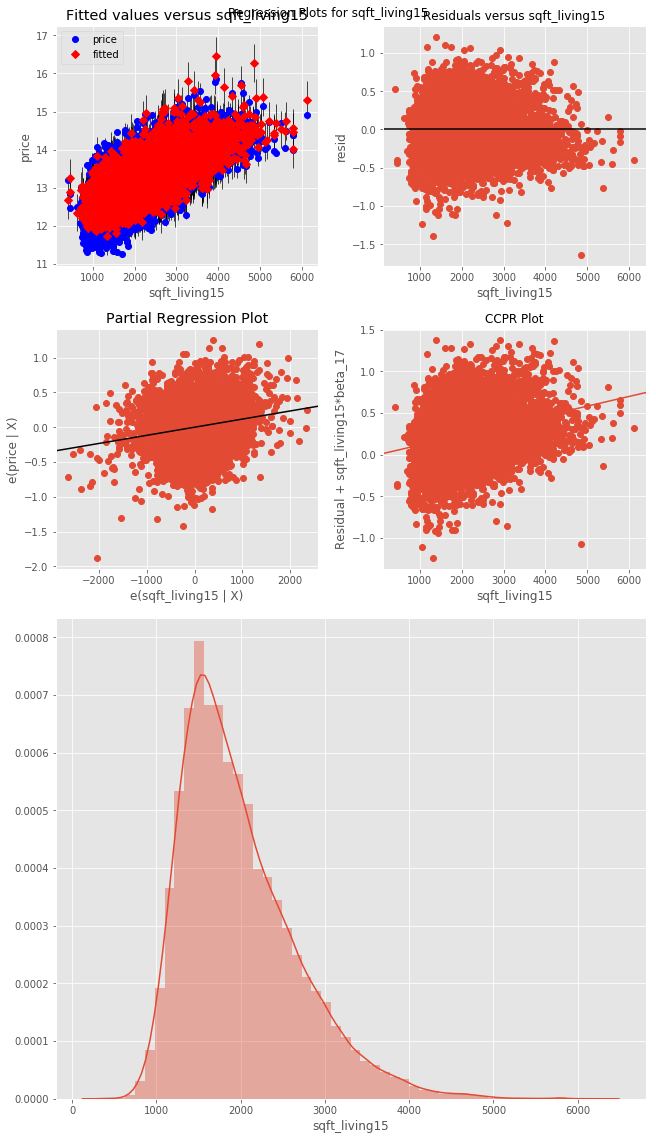

In [41]:
curr_feat_idx += 1

if curr_feat_idx < len(preliminary_model_features):
    scjpnregression.feature_regression_summary(
        kchd_cleaned_with_log_transformed_target_df[preliminary_model_features]
        , curr_feat_idx
        , target
        , model_fit_results
        , display_regress_diagnostics=True
    )

1. p-value is low but VIF is high indicating colinearity, therefore this p-value should not be trusted
2. appears to be *continuous*
    1. distribution is skewed to the left
    2. needs to be *log-transformed* in order to push its distriubution more towards normal

In [42]:
cont_feats_to_be_logtransformed.append('sqft_living15')

C:\Users\tripp\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


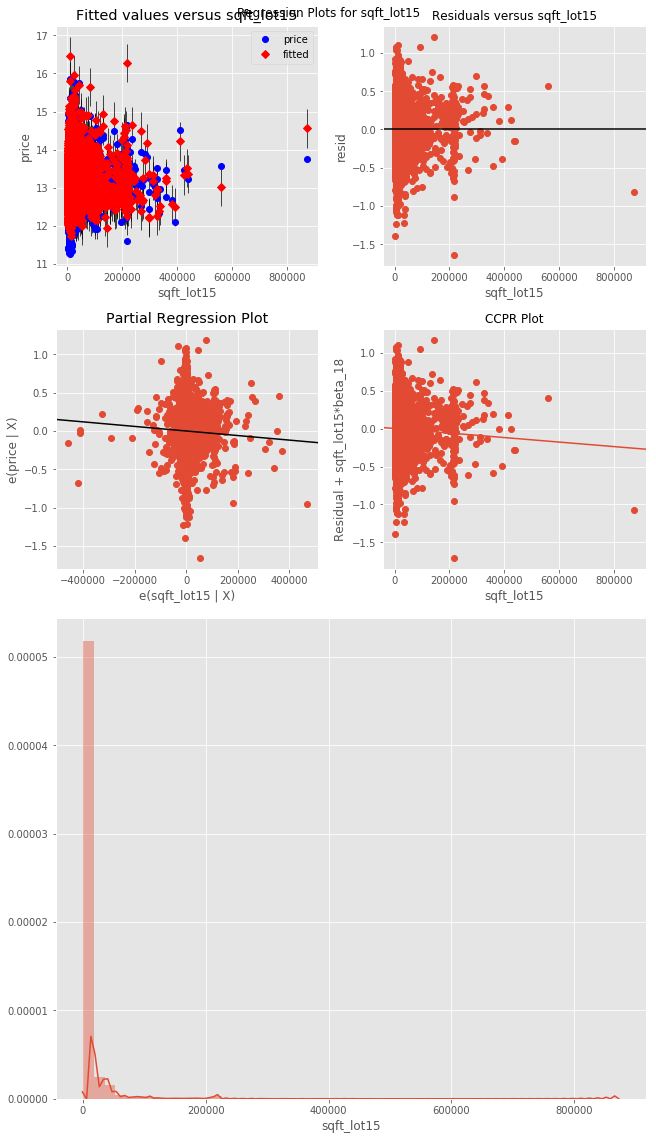

In [43]:
curr_feat_idx += 1

if curr_feat_idx < len(preliminary_model_features):
    scjpnregression.feature_regression_summary(
        kchd_cleaned_with_log_transformed_target_df[preliminary_model_features]
        , curr_feat_idx
        , target
        , model_fit_results
        , display_regress_diagnostics=True
    )

1. p-value is low and VIF is low, therefore this p-value can be trusted
2. appears to be *continuous*
    1. distribution is skewed to the left
    2. needs to be *log-transformed* in order to push its distriubution more towards normal

In [44]:
cont_feats_to_be_logtransformed.append('sqft_lot15')

In [45]:
curr_feat_idx += 1

if curr_feat_idx < len(preliminary_model_features):
    scjpnregression.feature_regression_summary(
        kchd_cleaned_with_log_transformed_target_df[preliminary_model_features]
        , curr_feat_idx
        , target
        , model_fit_results
        , display_regress_diagnostics=True
    )

In [46]:
#categorical features
display(HTML("<h3>Preliminary list of all <i>categorical</i> features:</h3>"))
s_html = "<ul>"
for cat_feat in categorical_features:
    s_html += "<li>{}</li>".format(cat_feat)
s_html += "</ul>"
display(HTML(s_html))
    
#continuous features
display(HTML("<h3>Preliminary list of all <i>continuous</i> features:</h3>"))
s_html = "<ul>"
for cont_feat in continuous_features:
    s_html += "<li>{}</li>".format(cont_feat)
s_html += "</ul>"
display(HTML(s_html))

#continuous features that will be log-transformed
display(HTML("<h3><i>Continuous</i> features that will be <i>log-transformed</i>:</h3>"))
s_html = "<ul>"
for cont_feat_to_be_logtransformed in cont_feats_to_be_logtransformed:
    s_html += "<li>{}</li>".format(cont_feat_to_be_logtransformed)
s_html += "</ul>"
display(HTML(s_html))

## Step 4: Feature Scaling, Normalization, Transformation, and Categorization

The strategy is to **refine *continuous* vs. *categorical* features *separately* and then combine the results to build the final model**.

We have our features partitioned into our *preliminary* list of *continuous* and *categorical* features, as well as the subsets of each that need additional preprocessing.

We will start with preprocessing our *continuous* features that need to be log-transformed.

<br><br>
### Continuous Feature Transformation Preprocessing

Prior to *log-transforming* these features, we must pay careful attention to features with values $\le 0$ and either adopt a replacement heuristic for these values to make log-transformation possible OR we can opt to simply not transform such a feature.

Note that **long** contains negative values and also that **lat** and **long** are really components of an *ordered pair*.  Thus, if we *transform* or *scale* one (but not *translate*), we must do the same operation to the other.  Without doing anything to address negative values, we will not be able to use *log-transformation* on **long** (and subsequently **lat**).  

However, **we can perform *log-transformation* on *long* if we first *translate (shift to the right)* its *lower-bound* to $0$ by adding $-1 \cdot min(long)$ to the all values in the set**.  Note that we must follow up with a *hack* in order to perform *log-transformation* on values==$0$: **we will subsequently replace all instances of $0.0$ with $1$ *in order to make log-transformation possible* - note that $log(1)=0$**.

To summarize:
1. For **lat** and **long**:
    1. first *translate* the *range* of **long** to: $range_{transformed}(long)=[min(range_0(long))-min(range_0(long)), max(range_0(long))-min(range_0(long))]$; that is, $\forall v \in range_0(long): v_{transformed} = v-min(range_0(long))$
    2. since they constitute an *ordered pair*:
        1. *translation* of a componenent of the ordered pair - i.e. **long** - independently from the other is okay
        2. but  *transformation/scaling* operations must be done to both
2. For all continuous features (including **lat** and **long**), we will:
    1. replace all instances of 0.0 with 1 *in order to make log-transformation possible*, since $log(1)=0$
    2. do *min/max scaling*.
    
The following code preprocesses and prepares **lat** and **long** for *log-transformation*.

<br><br>
#### Preprocess *lat* and *long* for *log-transformation*

We must add $-1 \cdot min(long)$ to the all values in the set, and then replace all instances of $0.0$ with $1$ so that we can *log-transform* these features.

In [47]:
kchd_transformed_and_scaled_df = kchd_cleaned_df.copy()

#prep for log-tranformation
kchd_transformed_and_scaled_df['long'] = kchd_transformed_and_scaled_df['long']-kchd_transformed_and_scaled_df['long'].min() # translation to [0, max(range(long)) - min(range(long))]
for lt_feature in cont_feats_to_be_logtransformed:
    scjpnutils.clean_offending_values(
        kchd_transformed_and_scaled_df
        , numeric_replacement_rules=
            {
                lt_feature: [(0.0, 1)]
            }
        , friendly_name_of_df="Preliminary Features in King County House Sales DF to be log-transformed"
    )
df_has_neg_or_0 = kchd_transformed_and_scaled_df[cont_feats_to_be_logtransformed] <= 0.0
for ltfeat in cont_feats_to_be_logtransformed:
    if df_has_neg_or_0[ltfeat].sum() > 0:
        cont_feats_to_be_logtransformed.remove(ltfeat)
if 'lat' in cont_feats_to_be_logtransformed and 'long' not in cont_feats_to_be_logtransformed:
    cont_feats_to_be_logtransformed.remove('lat')
if 'long' in cont_feats_to_be_logtransformed and 'lat' not in cont_feats_to_be_logtransformed:
    cont_feats_to_be_logtransformed.remove('long')

*** CLEANING VALUES of Preliminary Features in King County House Sales DF to be log-transformed: BEGIN ***
Rules for 'sqft_living' column value replacement are: [(0.0, 1)]
Looking for rows with 'sqft_living' values [0.0] ...
There are no rows that contain values of 'sqft_living' in [0.0]!
*** CLEANING VALUES of Preliminary Features in King County House Sales DF to be log-transformed: END ***
*** CLEANING VALUES of Preliminary Features in King County House Sales DF to be log-transformed: BEGIN ***
Rules for 'sqft_lot' column value replacement are: [(0.0, 1)]
Looking for rows with 'sqft_lot' values [0.0] ...
There are no rows that contain values of 'sqft_lot' in [0.0]!
*** CLEANING VALUES of Preliminary Features in King County House Sales DF to be log-transformed: END ***
*** CLEANING VALUES of Preliminary Features in King County House Sales DF to be log-transformed: BEGIN ***
Rules for 'sqft_above' column value replacement are: [(0.0, 1)]
Looking for rows with 'sqft_above' values [0.0] 

Both **lat** and **long** are now ready for *log-transformation*.

We can now not only perform log-transformation on **lat** and **long**, but on the rest of the remaining *continuous* features that need to be *log-transformed*, as well.  **We will also perform *min-max scaling***.

In [48]:
mm_features = continuous_features
print("\nThe following continuous features will be log-transformed:\n{}".format(cont_feats_to_be_logtransformed))
print("\nThe following continuous features will be min-max scaled:\n{}".format(mm_features))


The following continuous features will be log-transformed:
['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

The following continuous features will be min-max scaled:
Index(['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


<br><br>
### Perform *log-transformation* and *min-max scaling* on all continuous features

In [49]:
# log-transformation
kchd_transformed_and_scaled_df = scjpnutils.log_transform(
    kchd_transformed_and_scaled_df
    , cont_feats_to_be_logtransformed
)

# min-max scaling
kchd_transformed_and_scaled_df = scjpnutils.min_max_scaling(
    kchd_transformed_and_scaled_df
    , mm_features
)

<br><br>
### Perform *log-transformation* and *min-max scaling* on target, price

Don't forget that **our target feature (*price*) should be log-transformed** (and scaled), as well, *based on the results from our Preliminary Linear Regression Model*. 

In [50]:
kchd_transformed_and_scaled_df[target].describe().loc[['min', 'max']]

min      78000.0
max    7700000.0
Name: price, dtype: float64

In [51]:
kchd_transformed_and_scaled_df = scjpnutils.min_max_scaling(
    scjpnutils.log_transform(kchd_transformed_and_scaled_df, [target])
    , [target]
)

<br><br>
#### Ranges of *log-transformed* and *min-max scaled* *continuous* features and target, *price*:

In [52]:
target_plus_cont_feats = [target]
target_plus_cont_feats.extend(continuous_features)
kchd_transformed_and_scaled_df[target_plus_cont_feats].describe().loc[['min', 'max']]

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


<br><br>
### Distributions and Linearity Study, after scaling/transforming *continuous* features (and target)

Now let's have a look at our scaled and transformed data (*continuous* features).

C:\Users\tripp\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


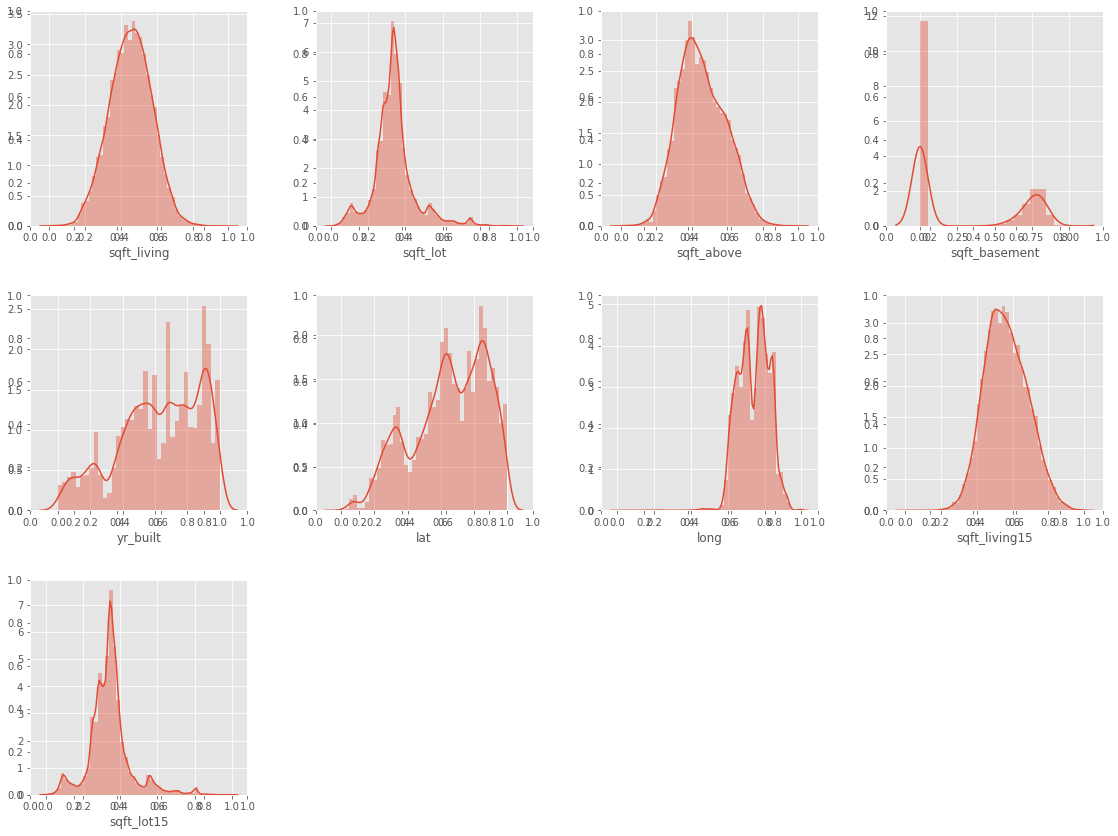

In [53]:
scjpnregression.histograms(kchd_transformed_and_scaled_df[continuous_features]);

After *log-transforming* our *continuous* features (*as well as our target feature*), we see that their distributions are more normal, with the exception of **sqft_basement**, **yr_built**, **lat**, and **long**.  

In terms of transformation, those features are about as good as they're going to get. 

Nevertheless, **we should expect the performance of a new linear regression based on this newly scaled/transformed data to perform "better" than the last one** - here "better" means more accurately predicting **price**, not necessarily a higher $R^2$ value.

Before building a new linear regression model, let's take a look at the scatterplots of our log-transformed data to see if it improves any apparent linearity between the target, **price**, which has also been log-transformed based on the hints we gleaned from the first model.

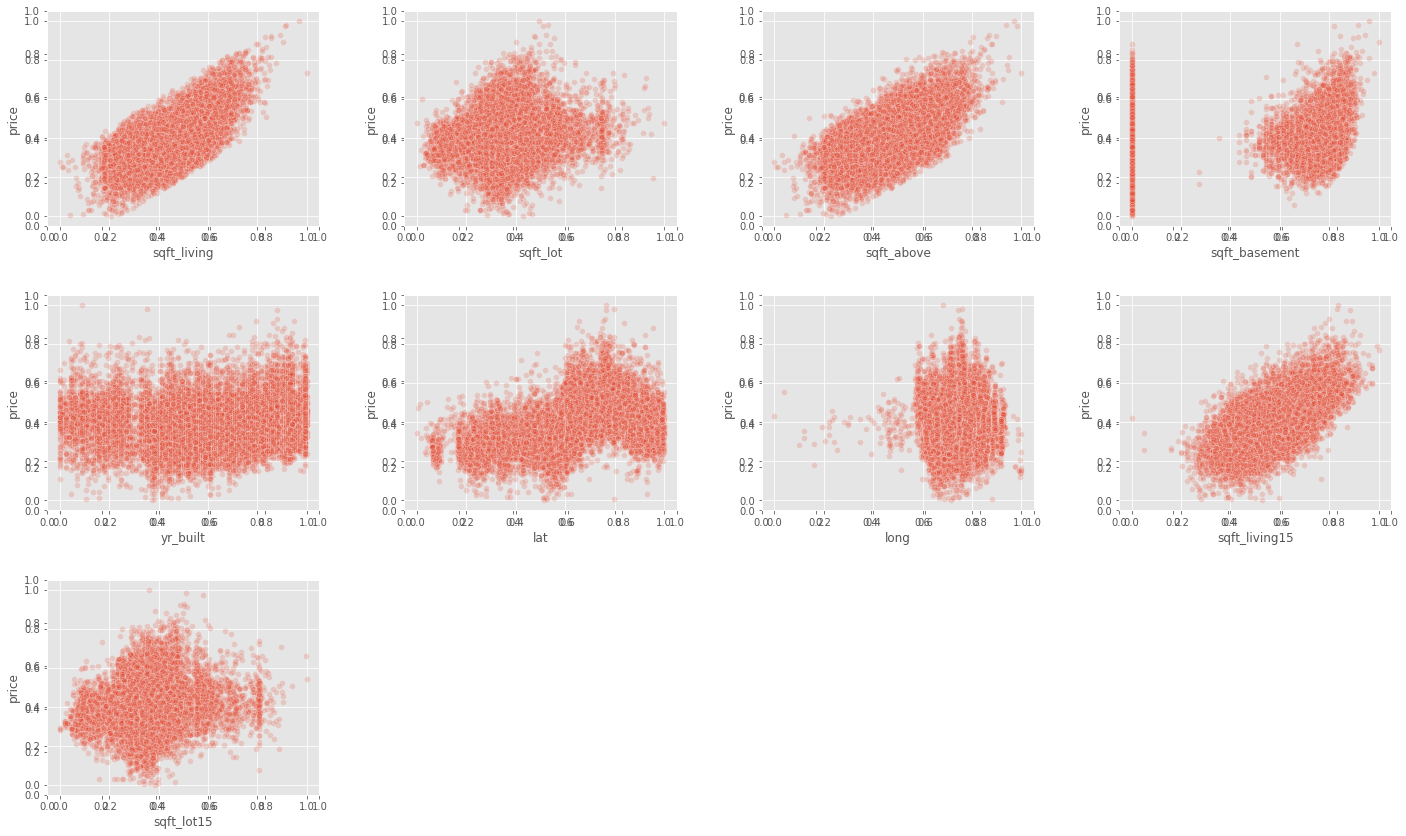

In [54]:
scjpnregression.scatter_plots(
    kchd_transformed_and_scaled_df[target_plus_cont_feats]
    , target
)

At first glance, log-transformation has made a big difference (for the better) in linearity between the target and most continuous features.  

There is apparently STRONG linearity between *log-transformed* **price** and:
1. *log-transformed* **sqft_living**
2. *log-transformed* **sqft_above**
3. *log-transformed* **sqft_living15**

For *log-transformed* **sqft_basement**, it looks like there could be some linearity.

<br>

But for the remaining log-transformed continuous features below, linearity between the log-transformed target, **price**, is debatle:

1. *log-transformed* **sqft_lot** (moderate)
2. *log-transformed* **yr_built** (not evident)
3. *log-transformed* **lat** (not evident)
4. *log-transformed* **long** (not evident)
5. *log-transformed* **sqft_lot15** (moderate)

So we will definitely retain the log-transformations of at least:
1. **sqft_living**
2. **sqft_above**
3. **sqft_basement**
3. **sqft_living15**
4. **sqft_lot**
5. **sqft_lot15**

Let's compare the scatterplots and distributions of the the relationships between the following features NOT log-transformed vs. log-transformed target to determine what to do with them:
1. **yr_built**
2. **lat**
3. **long**

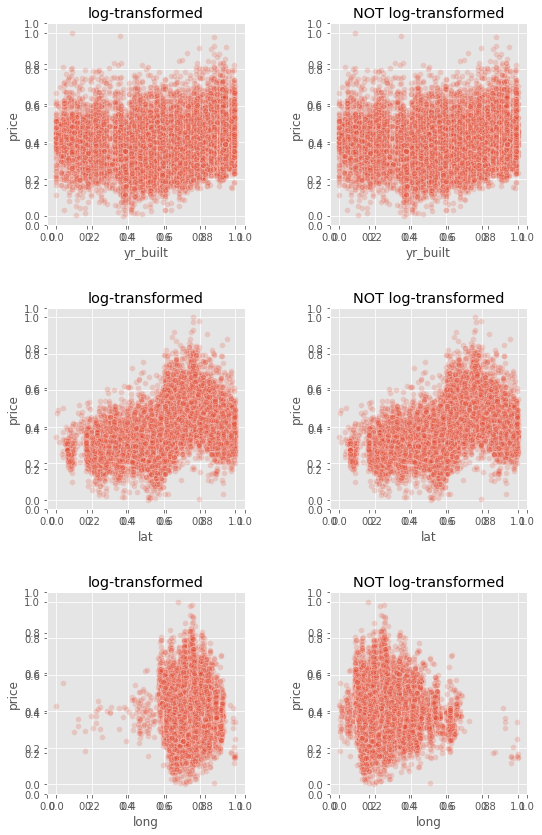

C:\Users\tripp\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


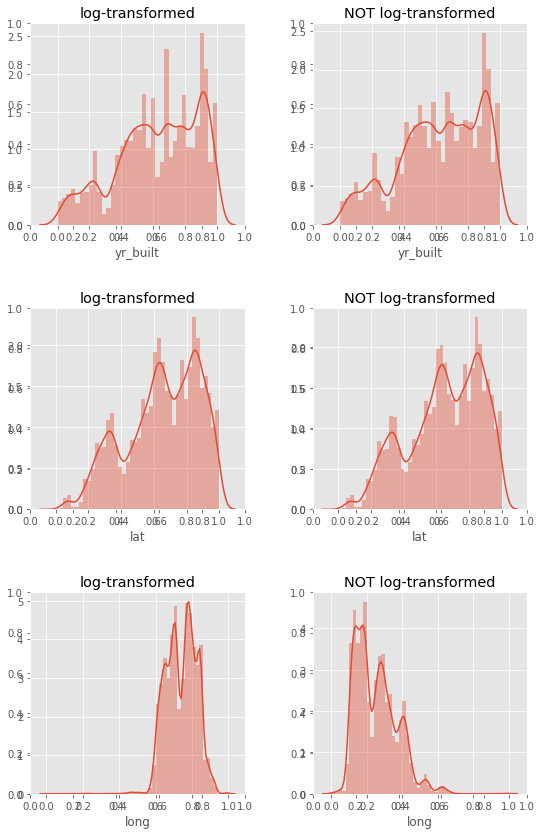

In [55]:
confirmed_lt_cont_features = ['sqft_living', 'sqft_above', 'sqft_basement', 'sqft_lot', 'sqft_living15', 'sqft_lot15']
check_non_lt_cont = ['yr_built', 'lat', 'long']

kchd_check_non_lt_cont_df = kchd_cleaned_df.copy()

# min-max scaling
kchd_check_non_lt_cont_df = scjpnutils.min_max_scaling(
    kchd_check_non_lt_cont_df
    , check_non_lt_cont
)

# log-transform, min-max scale target
kchd_check_non_lt_cont_df = scjpnutils.min_max_scaling(
    scjpnutils.log_transform(kchd_check_non_lt_cont_df, [target])
    , [target]
)

target_plus_check_non_lt_cont_feats = [target]
target_plus_check_non_lt_cont_feats.extend(check_non_lt_cont)

scjpnregression.scatterplot_comparison(
    kchd_transformed_and_scaled_df[check_non_lt_cont]
    , kchd_check_non_lt_cont_df[check_non_lt_cont]
    , kchd_transformed_and_scaled_df[[target]]
    , kchd_check_non_lt_cont_df[[target]]
    , "log-transformed"
    , "NOT log-transformed"
)
display(HTML("<br><br>"))
scjpnregression.histograms_comparison(
    kchd_transformed_and_scaled_df[check_non_lt_cont]
    , kchd_check_non_lt_cont_df[check_non_lt_cont]
    , "log-transformed"
    , "NOT log-transformed"
)

We see that linearity between *log-transformed* features above makes very little difference.

**long** is interesting in that either way there appears to be no linear relationship between *log-transformed* **long** vs. *log-transformed* **price** and *non-log-transformed* **long** vs. *log-transformed* **price**.  HOWEVER, the distribution of *log-transformed* **long** has a more normal-shaped distribution (but it is skewed right) than its *non-log-transformed* counterpart, with a less normal-shaped distibution that is skewed left.

<br><br>
#### Conclusion:
The following continuous features will NOT be *log-transformed* (but will still be *min-max scaled*):
1. **yr_built**
2. **lat**
3. **long**

<br><br>
### Commit *continuous* feature selection and subset of those that will be *log-transformed* for Preliminary Linear Regression Model v 2.0

In [56]:
final_lt_cont_features = confirmed_lt_cont_features.copy()
final_non_lt_cont_features = ['yr_built', 'lat', 'long']

cont_feats_to_drop = []
for cont_feat_to_drop in cont_feats_to_drop:
    if cont_feat_to_drop in final_lt_cont_features:
        final_lt_cont_features.remove(cont_feat_to_drop)
    if cont_feat_to_drop in final_non_lt_cont_features:
        final_non_lt_cont_features.remove(cont_feat_to_drop)

kchd_transformed_and_scaled_df = kchd_cleaned_df.copy()

#prep for log-tranformation
for lt_feature in final_lt_cont_features:
    scjpnutils.clean_offending_values(
        kchd_transformed_and_scaled_df
        , numeric_replacement_rules=
            {
                lt_feature: [(0.0, 1)]
            }
        , friendly_name_of_df="Preliminary Features in King County House Sales DF to be log-transformed"
    )
    
kchd_transformed_and_scaled_df = kchd_transformed_and_scaled_df.drop(cont_feats_to_drop, axis=1)

# log-transformation of target
kchd_transformed_and_scaled_df = scjpnutils.min_max_scaling(
    scjpnutils.log_transform(kchd_transformed_and_scaled_df, [target])
    , [target]
)
# log-transformation of final_lt_cont_features
kchd_transformed_and_scaled_df = scjpnutils.log_transform(
    kchd_transformed_and_scaled_df
    , final_lt_cont_features
)

# min-max scaling
kchd_transformed_and_scaled_df = scjpnutils.min_max_scaling(
    kchd_transformed_and_scaled_df
    , final_lt_cont_features + final_non_lt_cont_features
)

*** CLEANING VALUES of Preliminary Features in King County House Sales DF to be log-transformed: BEGIN ***
Rules for 'sqft_living' column value replacement are: [(0.0, 1)]
Looking for rows with 'sqft_living' values [0.0] ...
There are no rows that contain values of 'sqft_living' in [0.0]!
*** CLEANING VALUES of Preliminary Features in King County House Sales DF to be log-transformed: END ***
*** CLEANING VALUES of Preliminary Features in King County House Sales DF to be log-transformed: BEGIN ***
Rules for 'sqft_above' column value replacement are: [(0.0, 1)]
Looking for rows with 'sqft_above' values [0.0] ...
There are no rows that contain values of 'sqft_above' in [0.0]!
*** CLEANING VALUES of Preliminary Features in King County House Sales DF to be log-transformed: END ***
*** CLEANING VALUES of Preliminary Features in King County House Sales DF to be log-transformed: BEGIN ***
Rules for 'sqft_basement' column value replacement are: [(0.0, 1)]
Looking for rows with 'sqft_basement' v

<br><br>
### Study of lineary between *log-tranformed* target, *price*, vs. *categorical* features

Now let's carry out the same linearity study between *log-transformed* **price** and *categorical* features.

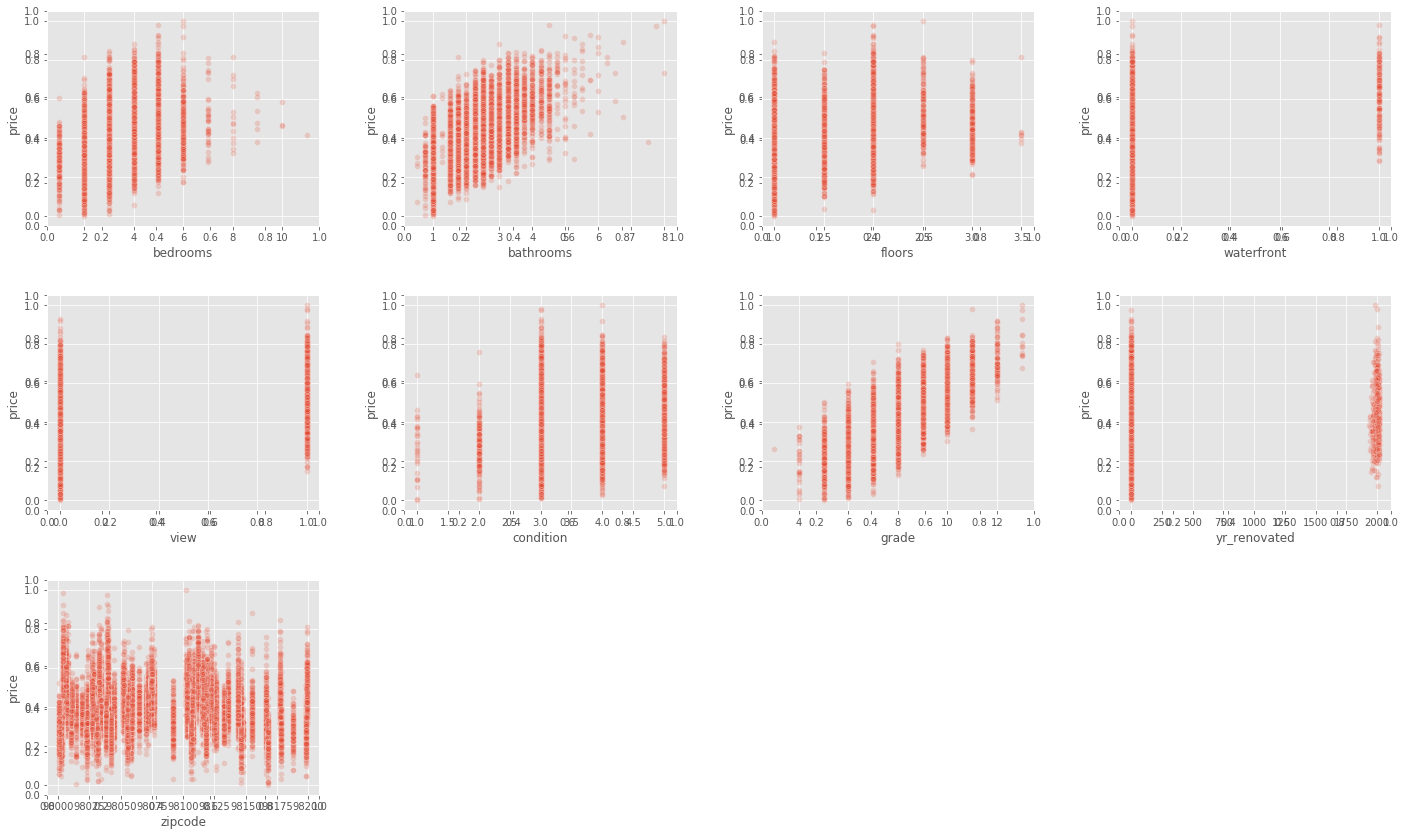

In [57]:
target_plus_cat_feats = [target]
target_plus_cat_feats.extend(categorical_features)
scjpnregression.scatter_plots(
    kchd_transformed_and_scaled_df[target_plus_cat_feats]
    , target
)

<br><brb>
    
#### Conclusion
For most categorical features, there appears to be a linear relationship with *log-transformed* **price**, except for **zipcode**.

So we can now commit to dropping **zipcode**.

<br><br>
### Commit *categorical* feature selection for Preliminary Linear Regression Model v 2.0

In [58]:
cat_feats_to_drop = ['zipcode']
for cat_feat_to_drop in cat_feats_to_drop:
    categorical_features.remove(cat_feat_to_drop)

kchd_transformed_and_scaled_df = kchd_transformed_and_scaled_df.drop(cat_feats_to_drop, axis=1)

<br><br>
### Ranges of values after committing to *categorical* features (but before binning)

In [59]:
kchd_transformed_and_scaled_df[categorical_features].describe().loc[['min', 'max']]

,bedrooms,bathrooms,floors,waterfront,view,condition,grade,yr_renovated
min,1.0,0.5,1.0,0.0,0.0,1.0,3.0,0.0
max,11.0,8.0,3.5,1.0,1.0,5.0,13.0,2015.0


<br><br>
### Preliminary Regression Model v 2.0, committed *continuous* (including *transformed*) vs. *categorical* features (but not yet binned)


formula: price~bedrooms+bathrooms+sqft_living+sqft_lot+floors+waterfront+view+condition+grade+sqft_above+sqft_basement+yr_built+yr_renovated+lat+long+sqft_living15+sqft_lot15


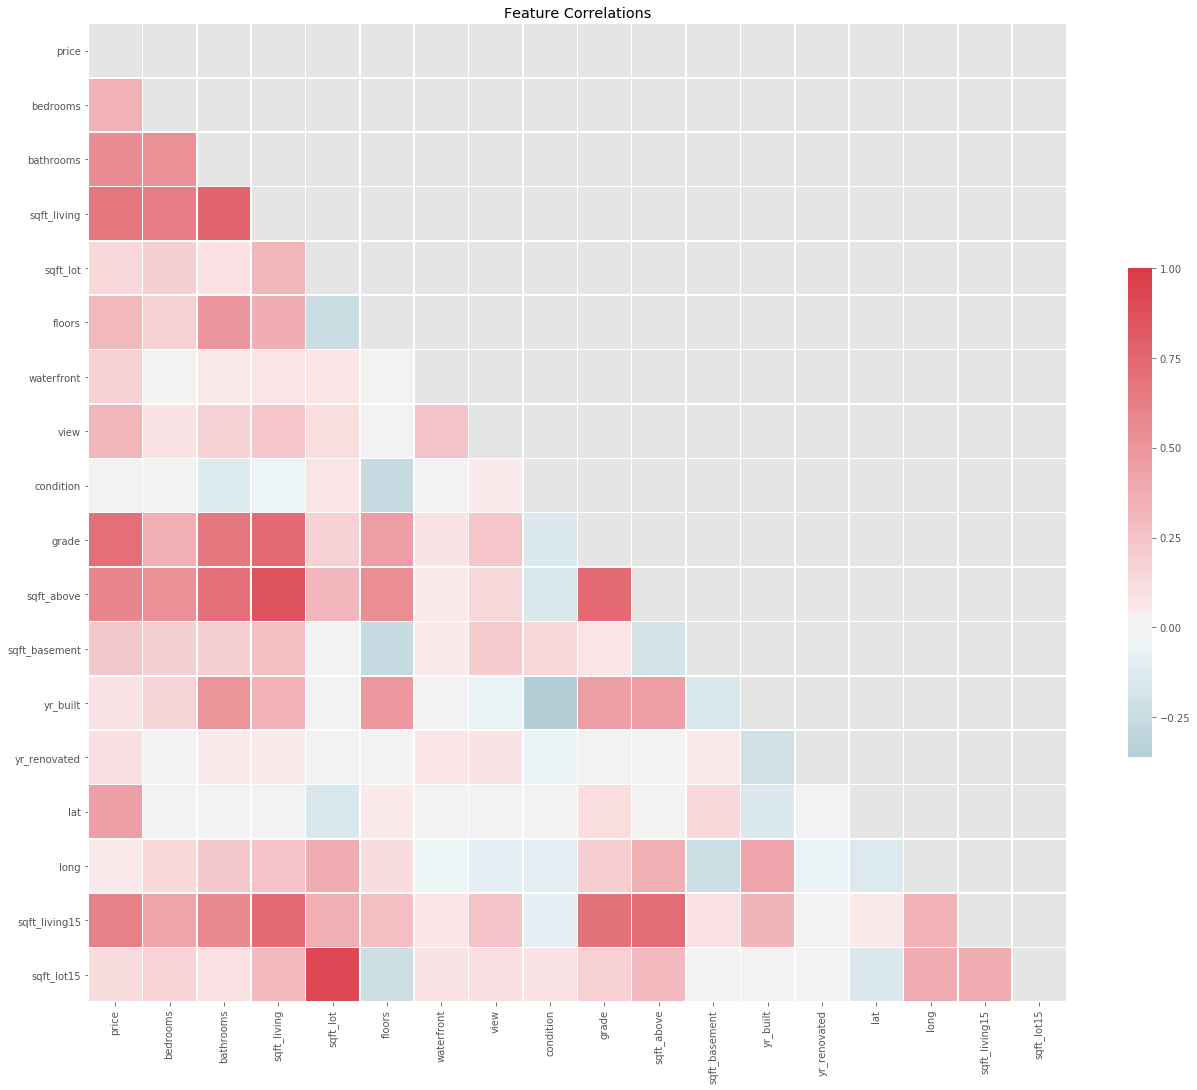

C:\Users\tripp\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


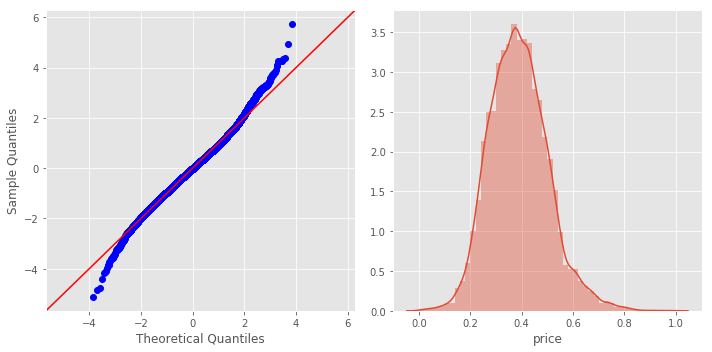

In [60]:
prev_sel_features = sel_features
prev_train_score = train_score
prev_test_score = test_score
(
    sel_features
    , X_train
    , X_test
    , y_train
    , y_test
    , train_score
    , test_score
    , model
) = scjpnregression.lin_reg_model(
    kchd_transformed_and_scaled_df.drop(['id', 'date'], axis=1)
    , target
    , title="Preliminary Regression Model v 2.0, committed <i>continuous</i> (including <i>transformed</i>) vs. <i>categorical</i> features (not binned):"
)

prev_good_vif_features = good_vif_features
prev_bad_vif_features = bad_vif_features
prev_model_fit_results = model_fit_results
(model_fit_results, good_vif_features, bad_vif_features) = scjpnregression.model_fit_summary(
    kchd_transformed_and_scaled_df.drop(['id', 'date'], axis=1)
    , sel_features
    , target
    , model
    , train_score
    , test_score
    , mv_r_sq_th
    , mv_delta_score_th
    , mv_bad_vif_ratio_th
)

<br><br>
### Preliminary Regression Model v 2.0, committed *continuous* (including *transformed*) vs. *categorical* features (not binned): ANALYSIS

#### By how much have we improved from the last model?

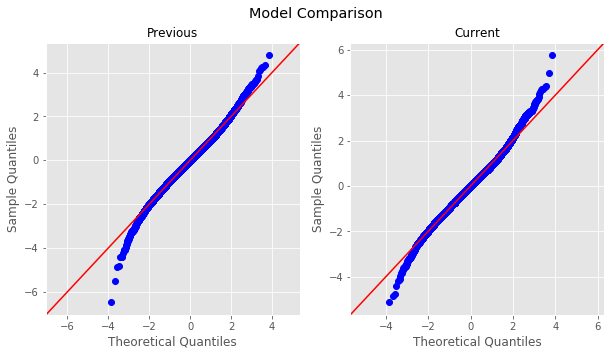

In [61]:
scjpnregression.mfrs_comparison(
    mfrs=[prev_model_fit_results, model_fit_results]
    , scores_dict={
        'method': scjpnregression.rmse_train_and_rmse_test
        , 'scores': [(prev_train_score, prev_test_score), (train_score, test_score)]
    }
)

We see that our $R^2$ has improved but only by a miniscule amount.

$RMSE$ and $\Delta RMSE$ have dropped quite a bit.  

$\Delta RMSE$ has improved by a factor of 5!

This is MAJOR improvement.

The ***Condition Number* improved** but is still quite bad: **multicolinearity is still an issue**.

**This model manifests a kurtosis that is clearly platykurtic**.  It's not ideal but at least it's not leptokurtic

<br><br>
#### What can we do to improve its performance?
Let's try to improve the situation by reducing colinearity.

But first, let's wrap up our committed features by dropping the obvious: **condition** does not exhibit a linear relationship with *log-transformed* **price**.

<br><br>
### Commit final feature-basis to submit to Cross-Validation Forward Selection

In [62]:
cat_feats_to_drop = ['condition']
for cat_feat_to_drop in cat_feats_to_drop:
    categorical_features.remove(cat_feat_to_drop)

kchd_transformed_and_scaled_df = kchd_transformed_and_scaled_df.drop(cat_feats_to_drop, axis=1)

kchd_transformed_and_scaled_df.set_index('id').to_csv('kc_house_transformed_and_scaled_data.csv', sep=',')

<br><br>
### Reducing Colinearity: Submit committed feature-basis to Cross-Validation Forward Selection

So, the fun begins.

Here, I use the greedy algorithm I wrote to forward-select the best combination of features out of the comitted features.  For details on how this is done, please refer to the [Cross-Validation Forward Selection of Features](Appendix.ipynb) section in the appendix.

Note that this takes a very long time to complete, which is why I have written a separate notebook to do it.

To see the results, just open the [Cross-Validation Forward Selection of Features RESULT](CrossValFeatureSelection.ipynb) notebook.

Note that **if you do re-run the [Cross-Validation Forward Selection of Features](CrossValFeatureSelection.ipynb) notebook, you will have to re-run THIS notebook in order to use those results**.

<br><brb>

### Import Cross-Validation Forward Selection Results and adjust final feature set for Final Preliminary Linear Regression Model

In [63]:
import ast
optimized_feature_subset_df = pd.read_csv('kc_cv_sel_optimized_features.csv')
cv_sel_features = optimized_feature_subset_df.tail(1)['features'].values[0]
cv_sel_features = ast.literal_eval(cv_sel_features)

print("Cross-Validation Forward Selected features are: {}\n".format(cv_sel_features))

to_drop_lt_cont_feats = []
to_drop_nonlt_cont_feats = []
# final_lt_cont_features + final_non_lt_cont_features

for final_lt_cont_feature in final_lt_cont_features:
    if final_lt_cont_feature not in cv_sel_features:
        to_drop_lt_cont_feats.append(final_lt_cont_feature)
for to_drop_lt_cont_feat in to_drop_lt_cont_feats:
    final_lt_cont_features.remove(to_drop_lt_cont_feat)
kchd_transformed_and_scaled_df = kchd_transformed_and_scaled_df.drop(to_drop_lt_cont_feats, axis=1)
print("dropped lt-cont features: {}".format(to_drop_lt_cont_feats))
for final_non_lt_cont_feature in final_non_lt_cont_features:
    if final_non_lt_cont_feature not in cv_sel_features:
        to_drop_nonlt_cont_feats.append(final_non_lt_cont_feature)
for to_drop_nonlt_cont_feat in to_drop_nonlt_cont_feats:
    final_non_lt_cont_features.remove(to_drop_nonlt_cont_feat)
kchd_transformed_and_scaled_df = kchd_transformed_and_scaled_df.drop(to_drop_nonlt_cont_feat, axis=1)
print("dropped nonlt-cont features: {}".format(to_drop_nonlt_cont_feats))
print("final lt-cont features: {}".format(final_lt_cont_features))
print("final nonlt-cont features: {}\n".format(final_non_lt_cont_features))

to_drop_categorical_features = []
for cat_feat in categorical_features:
    if cat_feat not in cv_sel_features:
        to_drop_categorical_features.append(cat_feat)       
for drop_cat_feat in to_drop_categorical_features:
    categorical_features.remove(drop_cat_feat)
kchd_transformed_and_scaled_df = kchd_transformed_and_scaled_df.drop(to_drop_categorical_features, axis=1)
print("dropped categorical features: {}".format(to_drop_categorical_features))
print("final categorical features: {}".format(categorical_features))

# remaining features in kchd_transformed_and_scaled_df (minus target and id and date) should be == cv_sel_features
remaining_df_predictors = list(kchd_transformed_and_scaled_df.drop([target, 'id', 'date'], axis=1).columns)
print(
    "features remaining in kchd_transformed_and_scaled_df: {} (equal to cv_sel_features? {})".format(
        remaining_df_predictors
        , set(remaining_df_predictors) == set(cv_sel_features)
    )
)

Cross-Validation Forward Selected features are: ['sqft_lot', 'waterfront', 'view', 'grade', 'yr_built', 'lat', 'sqft_living15', 'sqft_lot15']

dropped lt-cont features: ['sqft_living', 'sqft_above', 'sqft_basement']
dropped nonlt-cont features: ['long']
final lt-cont features: ['sqft_lot', 'sqft_living15', 'sqft_lot15']
final nonlt-cont features: ['yr_built', 'lat']

dropped categorical features: ['bedrooms', 'bathrooms', 'floors', 'yr_renovated']
final categorical features: ['waterfront', 'view', 'grade']
features remaining in kchd_transformed_and_scaled_df: ['sqft_lot', 'waterfront', 'view', 'grade', 'yr_built', 'lat', 'sqft_living15', 'sqft_lot15'] (equal to cv_sel_features? True)



formula: price~sqft_lot+waterfront+view+grade+yr_built+lat+sqft_living15+sqft_lot15


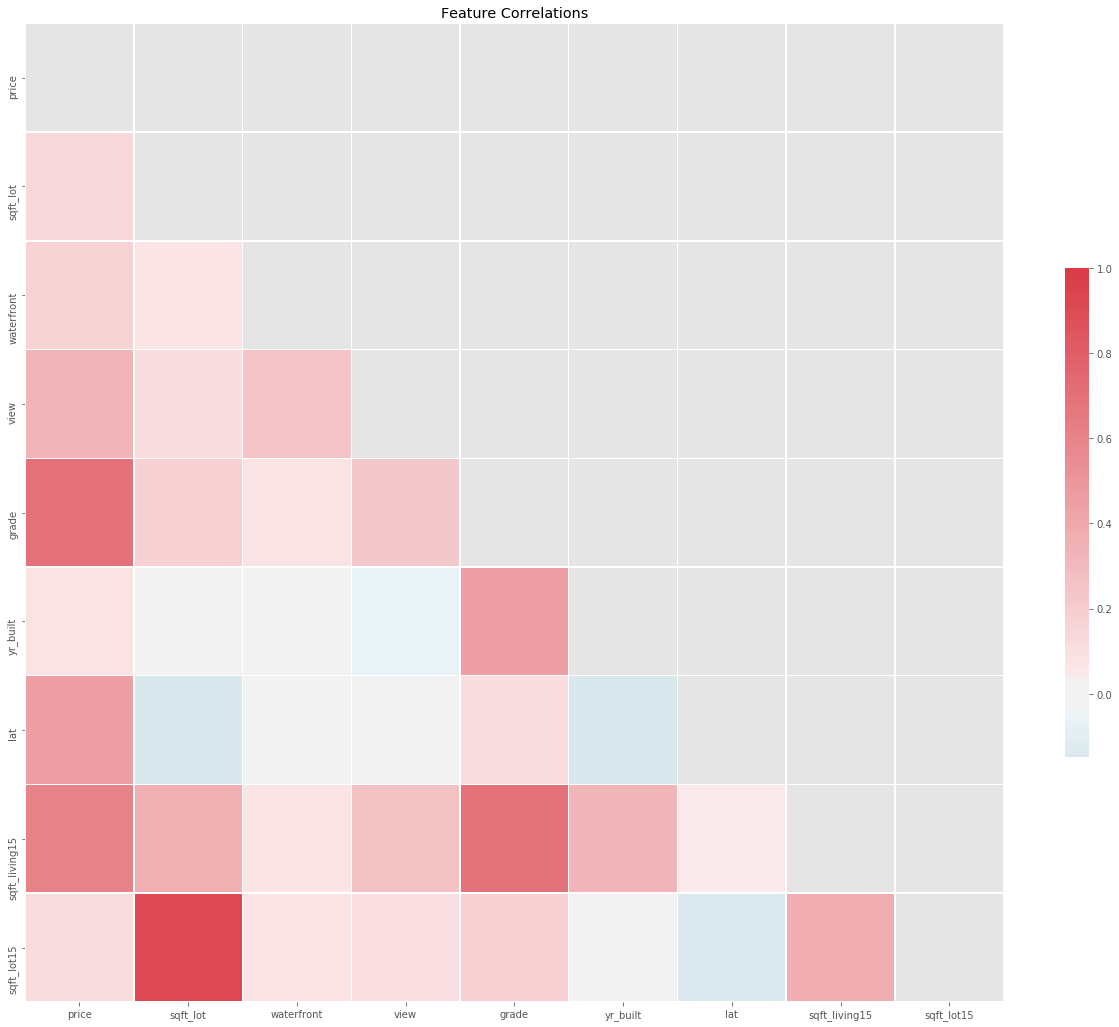

C:\Users\tripp\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


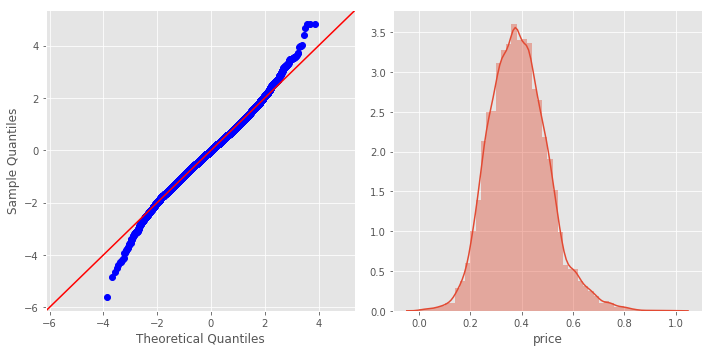

In [64]:
target_plus_cv_sel_features = [target]
target_plus_cv_sel_features.extend(cv_sel_features)

prev_sel_features = sel_features
prev_train_score = train_score
prev_test_score = test_score
(
    sel_features
    , X_train
    , X_test
    , y_train
    , y_test
    , train_score
    , test_score
    , model
) = scjpnregression.lin_reg_model(
    kchd_transformed_and_scaled_df[target_plus_cv_sel_features]
    , target
    , title="Preliminary Regression Model v 3.0, cross-validation forward selected features:"
)

prev_good_vif_features = good_vif_features
prev_bad_vif_features = bad_vif_features
prev_model_fit_results = model_fit_results
(model_fit_results, good_vif_features, bad_vif_features) = scjpnregression.model_fit_summary(
    kchd_transformed_and_scaled_df[target_plus_cv_sel_features]
    , sel_features
    , target
    , model
    , train_score
    , test_score
    , mv_r_sq_th
    , mv_delta_score_th
    , mv_bad_vif_ratio_th
)

<br><br>
### Preliminary Regression Model v 3.0, cross-validation forward selected features: ANALYSIS

#### By how much have we improved from the last model?

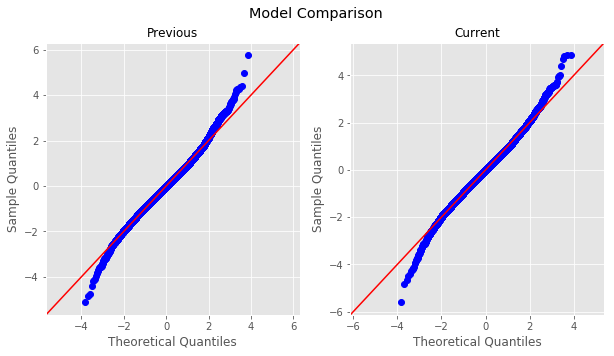

In [65]:
scjpnregression.mfrs_comparison(
    mfrs=[prev_model_fit_results, model_fit_results]
    , scores_dict={
        'method': scjpnregression.rmse_train_and_rmse_test
        , 'scores': [(prev_train_score, prev_test_score), (train_score, test_score)]
    }
)

Even though $R^2$ has dropped, this is by far the best model yet.  

$R^2$ is still high.  

Additionally, the gap between Adjusted $R^2$ and $R^2$ has dropped a bit.

$RMSE$ and $\Delta RMSE$ are still low.

More importantly, $\Delta RMSE$ has improved again (although not by much).

Best of all, we appear to have **almost completely mitigated multicolinearity**.  This is given by the value of Condition No. $\le 1000$.

But to get a visual feel, let's take a look a different view of the colinearity status of the set of cross-validation forward-selected features.  We have two views of colinearity below, where we check for the presence of 75% colinearity or greater.

In the first view, we hope to see very few `True` values other than along the diagonal.

In the second view, we hope to see very few bright cells other than along the diagonal.

,price,sqft_lot,waterfront,view,grade,yr_built,lat,sqft_living15,sqft_lot15
price,True,False,False,False,False,False,False,False,False
sqft_lot,False,True,False,False,False,False,False,False,True
waterfront,False,False,True,False,False,False,False,False,False
view,False,False,False,True,False,False,False,False,False
grade,False,False,False,False,True,False,False,False,False
yr_built,False,False,False,False,False,True,False,False,False
lat,False,False,False,False,False,False,True,False,False
sqft_living15,False,False,False,False,False,False,False,True,False
sqft_lot15,False,True,False,False,False,False,False,False,True


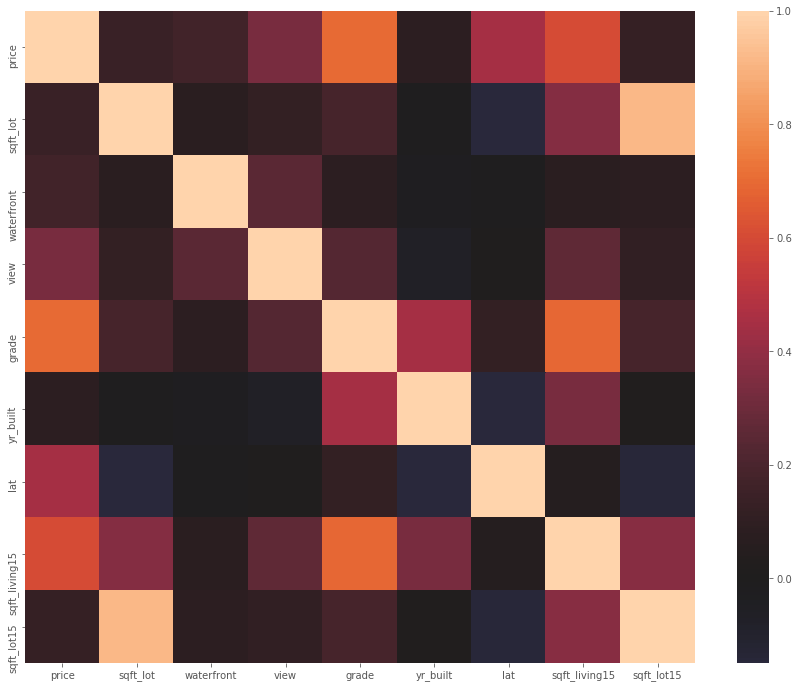

sqft_lot 92.0% correlated to sqft_lot15
sqft_lot15 92.0% correlated to sqft_lot

most severe correlation: ('sqft_lot', [('sqft_lot15', 0.92)])


({'sqft_lot': [('sqft_lot15', 0.92)], 'sqft_lot15': [('sqft_lot', 0.92)]},
 ('sqft_lot', [('sqft_lot15', 0.92)]))

In [66]:
scjpnregression.summarize_multicolinearity(kchd_transformed_and_scaled_df[target_plus_cv_sel_features], target)

Even though we already knew colinearity has been mitigated (by virtue of Condition No. $\le 1000$), the colinearity summaries above visually confirm our confidence, as well.

Therefore, **we can trust the p-values of each feature in this model**.  Additionally, **every feature included is statistically significant since its p-value is so low**.

The only cause for concern is in the plot of residuals.  The kurtosis is platykurtic, which is acceptable.  But, again, ideally we strive for a mesokurtic distribution of residuals.

Let's see if binning - that is, officially categorizing - our so-called "categorical" features will bring our distribution of residuals closer to mesokurtic.

<br><br>
### Step 4: Categorization/Binning Categorical Features

Now, before we get to officially *categorizing* our categorical features, we can refer to their ranges and sizes of their value sets in order to get some guidance on how we should "bin" them.

For numerically-valued categorical features with a small range of values, we *could* partition the categories (value set) based on the number of values.  But **binning in this case would provide no benefit vs. simply leaving the feature unbinned**.

Let's have a look at the categorical value set ranges once more.

In [67]:
display(HTML("<b>Categorical Feature Ranges:</b><br><br>"))
scjpnutils.print_df(kchd_cat_classification_df[kchd_cat_classification_df['name'].isin(categorical_features)][['name', 'dtype', 'unique_vals']].set_index('name'))

,dtype,unique_vals
name,,
waterfront,float64,"[0.0, 1.0]"
view,float64,"[0.0, 1.0]"
grade,int64,"[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]"


#### Conclusion:

**There is no need to categorize/bin these so-called "categorical" features**.

In fact, we can and probably should treat **grade** as a quantitative (*continuous*) feature, which means it should be *log-transformed* and *min-max scaled*!

This will be our last step before we build the Final Linear Regression Model:

In [68]:
kchd_final_df = kchd_transformed_and_scaled_df.copy()
categorical_features.remove('grade')
final_non_lt_cont_features.append('grade')
print("final_lt_cont_features: {}".format(final_lt_cont_features))
print("final_non_lt_cont_features: {}".format(final_non_lt_cont_features))
print("categorical_features: {}".format(categorical_features))

# log-transformation and min-max scaling of 'grade'
kchd_final_df = scjpnutils.min_max_scaling(
    scjpnutils.log_transform(kchd_final_df, ['grade'])
    , ['grade']
)

final_lt_cont_features: ['sqft_lot', 'sqft_living15', 'sqft_lot15']
final_non_lt_cont_features: ['yr_built', 'lat', 'grade']
categorical_features: ['waterfront', 'view']


<br><br>
### Final Linear Regression Model: incorporate all prior preliminary model improvements + treat *grade* as continuous


formula: price~sqft_lot+waterfront+view+grade+yr_built+lat+sqft_living15+sqft_lot15


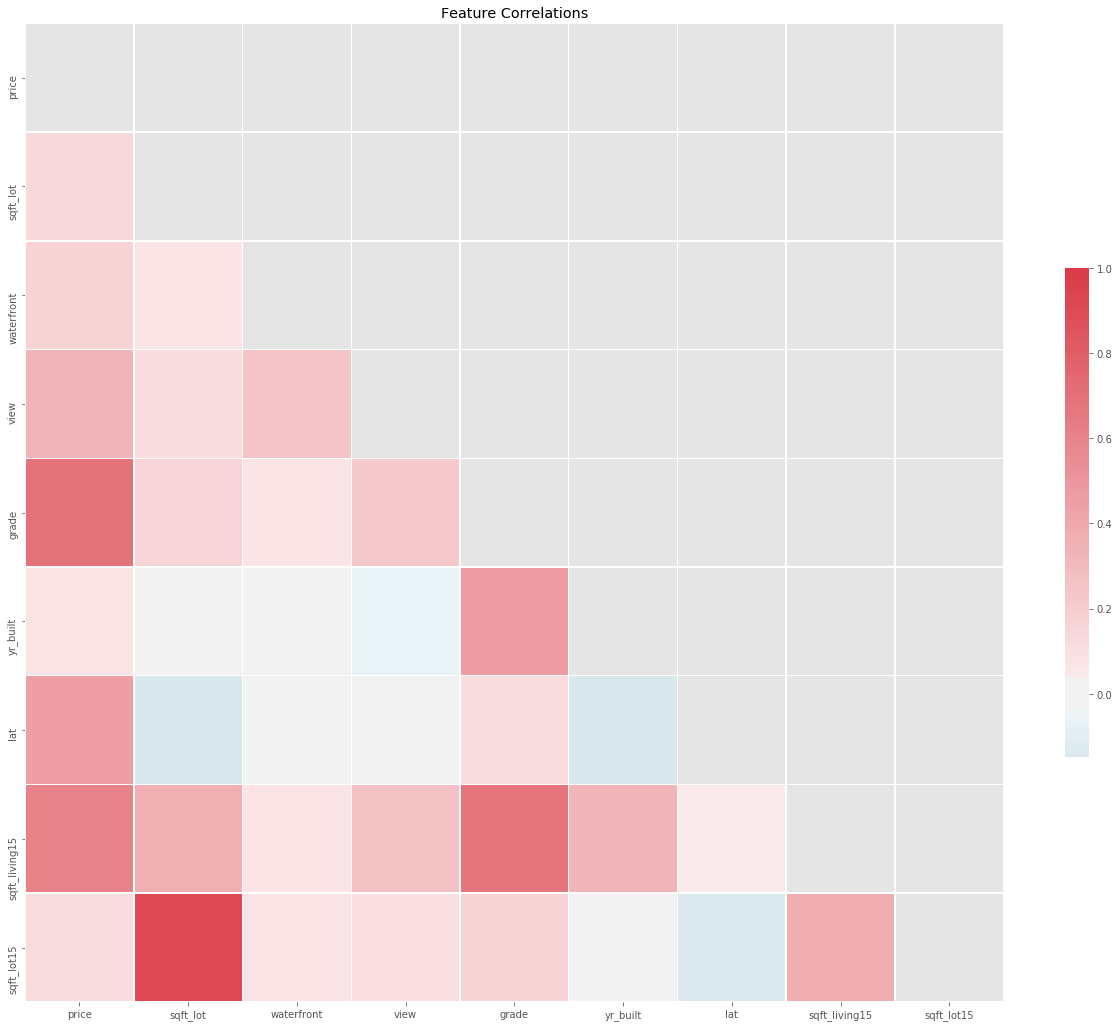

C:\Users\tripp\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


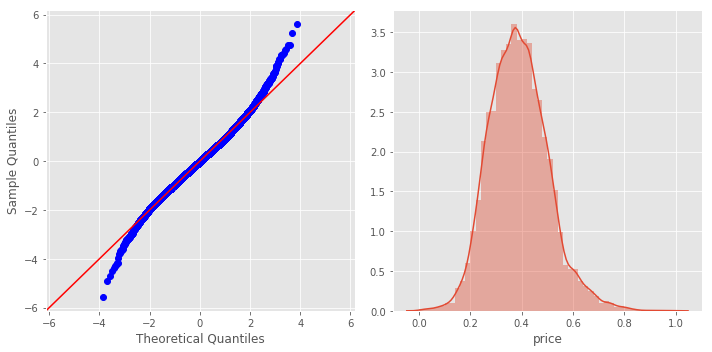

In [69]:
prev_sel_features = sel_features
prev_train_score = train_score
prev_test_score = test_score
(
    sel_features
    , X_train
    , X_test
    , y_train
    , y_test
    , train_score
    , test_score
    , model
) = scjpnregression.lin_reg_model(
    kchd_final_df[target_plus_cv_sel_features]
    , target
    , title="Final Linear Regression Model, incorporate all prior preliminary model improvements + treat <i>grade</i> as continuous"
)

prev_good_vif_features = good_vif_features
prev_bad_vif_features = bad_vif_features
prev_model_fit_results = model_fit_results
(model_fit_results, good_vif_features, bad_vif_features) = scjpnregression.model_fit_summary(
    kchd_final_df[target_plus_cv_sel_features]
    , sel_features
    , target
    , model
    , train_score
    , test_score
    , mv_r_sq_th
    , mv_delta_score_th
    , mv_bad_vif_ratio_th
)

<br><br>
### Final Linear Regression Model: incorporate all prior preliminary model improvements + treat *grade* as continuous: ANALYSIS

#### By how much have we improved from the last model?

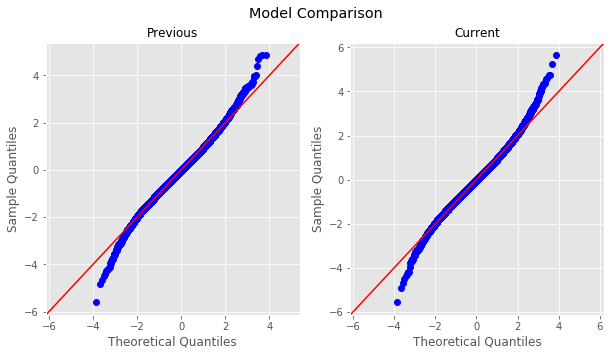

In [70]:
scjpnregression.mfrs_comparison(
    mfrs=[prev_model_fit_results, model_fit_results]
    , scores_dict={
        'method': scjpnregression.rmse_train_and_rmse_test
        , 'scores': [(prev_train_score, prev_test_score), (train_score, test_score)]
    }
)

There is not much to say but it is all good.  

$R^2$ has dropped again but not by much and it is still high.  

All predictors in this model are statstically significant with low *p-values*.

$RMSE$ has gotten a tad worse, as has $\Delta RMSE$ but, because **multicolinearity is virtually non-existent**, with Condition No. $= 52.8$ being well below $1000$, we have **high confidence** in each of these statstics and we will gladly trade a slight hit to $RMSE$ and $\Delta RMSE$ for the boost in confidence garnared by a smaller Condition No. 

Finally, although the distrubution of residuals is not mesokurtic, it most definitely is platykurtic, which is acceptable.

## Characteristics of Final Linear Regression Model which BEST predicts price

In [71]:
s_html = "To summarize the final model which BEST predicts our target, <b>price</b>, has the following characteristics:<ol>"
s_html += "<li>All features have been selected via <i>5 k-fold cross-validation</i> to best predict <b>price</b>.</li>"
s_html += "<li>The target, <b>price</b>, has been <i>log-transformed</i> and <i>min-max scaled</i>.</li>"
s_html += "<li><i>Continuous</i> features (optimized selection via Cross-Validation over 5 k-folds):<ol>"
for final_lt_cont_feature in final_lt_cont_features:
    s_html += "<li><b>{}</b> (<i>log-transformed</i> and <i>min-max scaled</i>)</li>".format(final_lt_cont_feature)
for final_non_lt_cont_feature in final_non_lt_cont_features:
    s_html += "<li><b>{}</b> (<i>min-max scaled</i>)</li>".format(final_non_lt_cont_feature)
s_html += "</ol></li>"
s_html += "<li><i>Categorical</i> features (optimized selection via Cross-Validation over 5 k-folds):<ol>"
for categorical_feature in categorical_features:
    s_html += "<li><b>{}</b></li>".format(categorical_feature)
s_html += "</ol></li>"
s_html += "<li>$R^2={}$</li>".format(model_fit_results.rsquared)
s_html += "<li>Adjusted $R^2={}$</li>".format(model_fit_results.rsquared_adj)
s_html += "<li>Condition No. $={}$ ($<<1000 \\implies$ NO SUBSTANTIAL MULTICOLINEARITY!)</li>".format(model_fit_results.condition_number)
s_html += "<li>$\\Delta RMSE={}$</li>".format(abs(test_score - train_score))

display(HTML(s_html))

## Step 5: Run linear regression experiments to answer real questions

### Step 5: Question 1: *As a whole, do structural features or zipcode influence home sale price more?*

#### Step 5: Question 1: Specifying "structural features" vs. "zipcode"
According to the definitions provided for our data set, the following features are "structural":
- **bedrooms**
- **bathrooms**
- **sqft_living**
- **sqft_lot**
- **floors**
- **waterfront**
- **condition**
- **grade**
- **sqft_above**
- **sqft_basement**
- **yr_built**
- **yr_renovated**

In [72]:
mv_r_sq_th = 0.60 # let's be a little more forgiving with our Coefficient of Determination since we are dealing with a reduced feature set

structural_features = [
    'bedrooms'
    , 'bathrooms'
    , 'sqft_living'
    , 'sqft_lot'
    , 'floors'
    , 'waterfront'
    , 'condition'
    , 'grade'
    , 'sqft_above'
    , 'sqft_basement'
    , 'yr_built'
    , 'yr_renovated'
]
(structural_features, delta_mse, to_drop) = scjpnregression.cv_selection(
    kchd_transformed_and_scaled_df.drop(target, axis=1)[structural_features]
    , kchd_transformed_and_scaled_df[[target]]
    , folds=5
    , scoring_method='mse_and_delta_mse'
)

kchd_structural_df = pd.concat(
    [
        kchd_transformed_and_scaled_df[[target]]
        , kchd_transformed_and_scaled_df[structural_features]
    ]
    , axis=1
    , join='inner'
)
(
    sel_features
    , model_fit_results
    , train_mse
    , test_mse
    , good_vif_features
    , bad_vif_features
    , kchd_structural_categorized_df
) = scjpnregression.run_full_regression_experiment(
    kchd_structural_df
    , target
    , to_drop=[]
    , tr=tr
    , mv_r_sq_th=mv_r_sq_th
    , mv_mse_delta_th=mv_mse_delta_th
    , mv_bad_vif_ratio_th=mv_bad_vif_ratio_th
    , p_cat=p_cat
    , fn_init_bin_bases=my_init_bin_bases
    , title="Full Regression Experiment, Question 1: Structural Features"
)
structural_sel_features = sel_features
structural_good_vif_features = good_vif_features
structural_bad_vif_features = bad_vif_features
structural_rsquared = model_fit_results.rsquared
structural_train_mse = train_mse
structural_test_mse = test_mse
   
location_features = ['zipcode']
kchd_location_df = pd.concat(
    [
        kchd_transformed_and_scaled_df[[target]]
        , kchd_transformed_and_scaled_df[location_features]
    ]
    , axis=1
    , join='inner'
)    
(
    sel_features
    , model_fit_results
    , train_mse
    , test_mse
    , good_vif_features
    , bad_vif_features
    , kchd_location_categorized_df
) = scjpnregression.run_full_regression_experiment(
    kchd_location_df
    , target
    , to_drop=[]
    , tr=tr
    , mv_r_sq_th=mv_r_sq_th
    , mv_mse_delta_th=mv_mse_delta_th
    , mv_bad_vif_ratio_th=mv_bad_vif_ratio_th
    , p_cat=0.99
    , fn_init_bin_bases=my_init_bin_bases
    , title="Full Regression Experiment, Question 1: zipcode alone"
)
location_sel_features = sel_features
location_good_vif_features = good_vif_features
location_bad_vif_features = bad_vif_features
location_rsquared = model_fit_results.rsquared
location_train_mse = train_mse
location_test_mse = test_mse

KeyError: "['bedrooms' 'bathrooms' 'sqft_living' 'floors' 'condition' 'sqft_above'\n 'sqft_basement' 'yr_renovated'] not in index"

### Step 5: Question 1: *As a whole, do structural features or does location influence home sale price more?*: Analysis

In [ ]:
display(HTML("The QQ plot of our regresssion model of <b>structural</b> features is outstanding!<br><b>$R^2 = {}$ of our model using structural features is decent</b>.<br><br>".format(round(structural_rsquared, 3))))
display(HTML("The QQ plot of our regresssion model of <b>location</b> features is decent.<br><b>$R^2 = {}$ of our model using location features is dismal</b>.<br><br>".format(round(location_rsquared, 3))))
display(
    HTML(
        "<b>The difference between MSE of our train/test partitions for both models is still very, very low at approximately ${}$ and ${}$, respectively.</b>".format(
            int(abs(structural_train_mse-structural_test_mse))
        , int(abs(location_train_mse-location_test_mse)))
    )
)
display(
    HTML(
        "Finally, <b>the bad VIF ratios - that is, measures of multicolinearity - are {}% and {}%, respectively</b>".format(
            round((len(structural_bad_vif_features)/len(structural_sel_features))*100, 2)
            , round((len(location_bad_vif_features)/len(location_sel_features))*100, 2)
        )
    )
)

Since conditions 2 and 3 have passed for both models, we can have confidence in the *Coefficient of Determination*, $R^2$, of each, respectively.

In [ ]:
display(HTML("<h2>CONCLUSION:</h2>"))
more_influential_feature_set = ""
more_influential_feature_set_probability = 0
less_influential_feature_set = ""
less_influential_feature_set_probability = 0
equal = False
equal_probability = 0
if structural_rsquared > location_rsquared:
    more_influential_feature_set = "structural"
    more_influential_feature_set_probability = round(structural_rsquared*100, 2)
    less_influential_feature_set = "location"
    less_influential_feature_set_probability = round(location_rsquared*100, 2)
elif location_rsquared > structural_rsquared:
    more_influential_feature_set = "location"
    more_influential_feature_set_probability = round(location_rsquared*100, 2)
    less_influential_feature_set = "structural"
    less_influential_feature_set_probability = round(structural_rsquared*100, 2)
else:
    equal = True
    equal_probability = round(structural_rsquared,2) # pick one or the other
display(
    HTML(
        "<h3>As a whole, based on the relative measures of the <i>Coefficients of Determinination</i> of <i>price</i>, we can say that <b>{}</b>.</h3>".format(
            "structural and location feature sets <i>equally</i> influence the sale price of homes in King's County" if equal 
            else 
                "<i>{}</i> features influence the sale price of homes in King's County more than <i>{}</i> features do.".format(
                    more_influential_feature_set
                    , less_influential_feature_set
                )
        )
    )
)

To get an intuitive feel that location does not much influence (very low $R^2!$) the sale price of homes in King's County, let's plot a heat map of sale price by location $(lat, long)$.  

### Explanation:
**Let's be clear about what we are asking, here**.  

**If there were some *linear* relationship between $price \sim (lat, long)$ then this means we should expect to see the sale price of a home increase as the coordinates of $(lat, long)$ do**.  How weird would that be?!

Clearly, this doesn't make sense.  **Intuitively, we understand that increasing sale price of a home most certainly is NOT determined by increasing $(lat, long)$**.  **It is then obvious that there is a problem in the *way* that we have asked that question**.

Let's take a look at the a heatmap of home sales, wherein a location "grows hotter" in the heatmap by increasing price.

The function below uses the ***folium* library for Python**  to build/display the heatmap.  Credit goes to Sivji (2017) as the original author of this function.  Of course, I have heavily modified it to suit my purposes.

In [ ]:
scjpnutils.map_points(
    kchd_df
    , plot_points=False
    , draw_heatmap=True
    , heat_map_weights_normalize=False
    , heat_map_weights_col='price'
    , heat_map_radius=8
    , zoom_start=9
)

**Clearly there is *SOME* relationship between $price \sim (lat, long)$, otherwise we would not see the clustering effect that we do** - i.e. we see regions of clustering/increasing "heat", indicating similar-priced home are grouped together in regions.  

**But that relationship is is certainly not *linear*** in nature... at least, **price** is not linearly related to $(lat, long)$.

For now, if we wanted to move forward with this, with the intent of predicting price based on $(lat, long)$, we could obviously create a mapping of region - perhaps some bounding box defined by $((lat, long)_{top\_left}, (lat, long)_{bottom\_right})$, for example.  This mapping would allows us to then "look" up home prices by $(lat, long)$.

BUT, my guess is that we would find that, given a fixed price range - i.e. the amount of "heat" above - we would find a similar set of structural features with very low probability.  In other words, the clustering in sale price of homes doesn't have much to do with common sets of structural features of neighbors.

### What's the bottom line?
**What really matters, mostly, in the end, in determining *price* is the set of structural features a given home has when looking at relationships established between $price \sim structural\_features)$ vs. $price \sim (lat, long)$ *from a linear regression perspective***.  Note that **we are NOT saying that, in general, *structural features* determine *price* more than *location* does** - to the contrary!  But what we are saying is that **linear regression is not enough to determine this in general**.

We can clearly see this since **the model using *structural* features as independents manifests kurtosis that is beautifully mesokurtic**.

**The kurtosis manifested in the $(lat, long)$ model isn't bad, per se, but the Coefficient of Determination, $R^2$, is basically worthless**.

But didn't we say this from the beginning?  Yes and no.  The conclusion was correct but was applied to the wrong semantic version of "location" within the context of our original question.  As it turns out, it is postulated, that $(lat, long)$ more or less simply references, or is equivalent to, a likely common set of structural features.

Having said that, what are the most influential structural features impacting the sale price of a home?

### Step 5: Question 2: Which structrual features affect the value of a home the most?

In this case, we want to restrict our investigation to features that are "truly" structural in nature.

According to the definitions of the features, **grade** is an evaluation of the home as a whole and is largely dependent on structural features of the home; therefore, we will exclude this feature from consideration.

All other structural features that we examined earlier, then, are "truly" structural in nature.

Let's run another regression experiment on the structural features, excluding **grade** this time.

## Conclusion:

The kurtosis manifested, by virtue of its QQ-plot, in this model is simply amazing!  The set of "true" structural features boasts a distribution in price that is fully mesokurtic with nominal outliers.

But since categorical features have been categorized, assessing which (categorical) features, ***prior* to categorization**, are the "most" influential is not straightforward.  So we simply judge each *binned* categorical feature as is.

We can judge how influential a feature is by virtue of its *p-value*.

Since muticolinearity is virtually non-existent, we have high confidence in the *p-value* of each feature.

Therefore, we can list the most influential features in determing **price** in this model simply by ordering the "GOOD" VIF features by increasing *p-value*.

They have already been listed in the output of our regression results but we list them again here, in decreasing order of influence - i.e. those listed first are the "most" influential in determing price and decrease in importance as we go down the list:

### Step 5: Bonus Question: What if we make some invalid assumptions about features? How can we use our tools to detect this?

Suppose, during the EDA phase, in examining the **y_built** and **yr_renovated** features, I surmised that these features are not, in fact, *categorical*.  Futher, suppose I surmise that new, *ephemoral*, *continuous* features can be derived from their values to indicate *elapsed time* of each.

Then, for:
1. **yr_built**, the *elapsed time* (in years) from **yr_built** until *today's date* represents the **age** of the home in years
2. **yr_renovated**, the *elapsed time* (in years) from **yr_renovated** until *today's date* represents the home's **yrs_since_renovated** (*if* **yr_renovated** $> 0$)

Clearly these are *continuous* (quantitative) values.  The (hypothetical) motivation in doing this is to derive higher fidelity in predicting the target, **price**.

So far, the logic seems sound.

BUT! There is a hidden "gotcha".  Can you spot it?

Okay time's up.

The answer lies in the *ephemoral* or *temporal* nature of these derived values.  These values would be computed at the time the regression is run.  Still don't see why this is a problem?  The final answer is that these values change!  All other data already in the data set remains fixed in time.

Okay.  Now that we have an understanding *beforehand* of the problem we might wonder, can any of these tools currently at our disposal detect that this is problematic assuming we didn't spot this up front?

Let's see.

But first, we must frame this problem in code.

The formula for **age** is: $age=today(year)-yr\_built$.

The formula for **yrs_since_renovated** is: $age=0\ if\ yr\_renovated=0\ else\ today(year)-yr\_renovated$.

In [ ]:
from datetime import date

dt_today = date.today()

kchd_transformed_and_scaled_with_ephemoral_df = kchd_transformed_and_scaled_df.copy()
kchd_transformed_and_scaled_with_ephemoral_df['age'] = dt_today.year - kchd_transformed_and_scaled_with_ephemoral_df['yr_built']
kchd_transformed_and_scaled_with_ephemoral_df['yrs_since_renovated'] = 0
kchd_transformed_and_scaled_with_ephemoral_df.loc[
    kchd_transformed_and_scaled_with_ephemoral_df['yr_renovated']!=0
    , ['yrs_since_renovated']
] = dt_today.year - kchd_transformed_and_scaled_with_ephemoral_df['yr_renovated']

scjpnutils.print_df_head(kchd_transformed_and_scaled_with_ephemoral_df[['yr_built', 'age', 'yr_renovated', 'yrs_since_renovated']])

Now suppose, being the good data scientists we are - albet evidently prone to the occasional but forgiveable misconception - that we do not forget to log-transform these values:

In [ ]:
to_be_lt_transformed_and_scaled = ['age', 'yrs_since_renovated']

# first must replace 0 with 1 to make log-transformation possible!
for lt_cont_feature in to_be_lt_transformed_and_scaled:
    scjpnutils.clean_offending_values(
        kchd_transformed_and_scaled_with_ephemoral_df
        , numeric_replacement_rules=
            {
                lt_cont_feature: [(0.0, 1)]
            }
        , friendly_name_of_df="King County House Sales DF"
    )

# now to log-transformation, then min-max scaling
kchd_transformed_and_scaled_with_ephemoral_df = scjpnutils.min_max_scaling(
    scjpnutils.log_transform(kchd_transformed_and_scaled_with_ephemoral_df, to_be_lt_transformed_and_scaled)
    , to_be_lt_transformed_and_scaled
)
kchd_transformed_and_scaled_with_ephemoral_df[['age', 'yrs_since_renovated']].describe().loc[['min', 'max']]

So far, so good.  Now, being the careful data scientists we strive to be, we drop **yr_built** and **yr_renovated** just to be sure it doesn't accidentally make it into our model:

In [ ]:
kchd_transformed_and_scaled_with_ephemoral_df.drop(['yr_built', 'yr_renovated'], axis=1, inplace=True)

scjpnutils.print_df_head(kchd_transformed_and_scaled_with_ephemoral_df)

Now let's run `split_categorical` to get our initial list of *continuous* vs. *categorical* features.

Note that there is a bit of irony incoming here, since **this function will "classify" both *age* and *yrs_since_renovated* as *categorical***!

Normally, this would be our first clue of our misstep but, for the sake of argument, let's look over this hint that our tools provide early on.

In [ ]:
(
    _
    , categorical_features
    , continuous_features
) = scjpnregression.split_categorical(kchd_transformed_and_scaled_with_ephemoral_df, p_cat, target)

As expected, the `split_categorical` function reports that both **age** and **yrs_since_renovated** are *categorical* with $p\_cat=0.9946$ and $p\_cat=0.9968$ (greater than 99% probability!), respectively.
 
Again, let's assume we look over this important hint that our tools provide... so we override and set both **age** and **yrs_since_renovated** as *continuous* features manually:

In [ ]:
continuous_features = [
    'sqft_living'
    , 'sqft_lot'
    , 'sqft_above'
    , 'sqft_basement'
    , 'lat'
    , 'long'
    , 'sqft_living15'
    , 'sqft_lot15'
    , 'age'
    , 'yrs_since_renovated'
]

categorical_features = list(kchd_transformed_and_scaled_with_ephemoral_df.drop(target, axis=1).columns)
for continuous_feature in continuous_features:
    categorical_features.remove(continuous_feature)
    
print("continuous_features:\n{}".format(continuous_features))
print("categorical_features:\n{}".format(categorical_features))

Looks great (although, ultimately, flawed!).

Let's run regression and behold the results of our amazing model-to-be!

But first, let's again use *cross-validation* to validate that our entire set of *continuous* features best predicts our target, **price**:

In [ ]:
(continuous_features, neg_mse, to_drop) = scjpnregression.cv_selection(
    kchd_transformed_and_scaled_with_ephemoral_df.drop(target, axis=1)[continuous_features]
    , kchd_transformed_and_scaled_with_ephemoral_df[[target]]
    , folds=5
    , scoring_method='mse_and_delta_mse'
)

What the... ?!?!

Really?!  After going through all that effort to derive this great new, "continuous" features, **age** and **yrs_since_renovated**, the `cv_selection` function has the gall to suggest dropping both?!

And here we reach the moral of the story.

We have seen that our tools have so kindly attempted to point out (multiple times, even) that we have made an error misclassifying *continuous* vs. *categorical features*.

**Final moral of the story**:

    Math works, people! That is, assuming you do it correctly.  So do your math!  Pay attention and do it correctly.  Listen to the results it gives.  And make the most of your tools!

We will go ahead now, out of sheer morbid curiosity, to conclude this exercise with the results we get if we run full regression based on this bad assumption.  It should serve as a nice parting thought!

In [ ]:
(
    sel_features
    , model_fit_results
    , train_mse
    , test_mse
    , good_vif_features
    , bad_vif_features
    , kchd_transformed_and_scaled_with_ephemoral_categorized_df
) = scjpnregression.run_full_regression_experiment(
    kchd_transformed_and_scaled_with_ephemoral_df
    , target
    , to_drop=[]
    , tr=tr
    , mv_r_sq_th=mv_r_sq_th
    , mv_mse_delta_th=mv_mse_delta_th
    , mv_bad_vif_ratio_th=mv_bad_vif_ratio_th
    , p_cat=p_cat
    , fn_init_bin_bases=my_init_bin_bases
    , cont_and_cat_features_tuple=(continuous_features, categorical_features)
    , title="Full Regression Experiment, Bonus Question"
)

### Closing thoughts: Bonus Question Regression Analysis

First, in spite of all that, the model is not horrible.  In fact, this is our highest $R^2$ yet!  But take a look at the kurtosis.  To say that it is platykurtic is a stretch.  This model has kurtosis right on the edge of being classified as leptokurtic.  Let's just call it what it is.  It's leptokurtic (but not as bad as our very first preliminary model's kurtosis).  This model is overfit!

The key take away, here is:
1. The extrememly high jump in $R^2$ should be looked upon with suspicion in any case.
2. `stepwise-selection`, for the first time in this study, found a fair amount of features that it considered statstically insignificant; granted, they're all bins of **zipcode**, which should make sense given our prior disucssion on *structural* vs. *location* features.
3. Instead of moving closer to mesokurtic kurtosis, we moved far away from it to leptokurtic kurtosis, the worst of all.

Take heed to what your tools tell you about your assumptions.  Trust math.

# *FIN*

# References

James, G., Witten, D., Hastie, T., & Tibshirani, R. (2012). An Introduction to Statistical Learning with Applications in R [Ebook] (7th ed.). New York, New York: Springer Science+Business Media. Retrieved from https://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf

statsmodels.regression.linear_model — statsmodels: model fit results summary. (2019). Retrieved 2 December 2019, from https://www.statsmodels.org/dev/_modules/statsmodels/regression/linear_model.html#RegressionResults.summary

Pawan, S. (2017). Predicting King County House Prices. Presentation, https://www.slideshare.net/PawanShivhare1/predicting-king-county-house-prices.

Does scikit-learn have forward selection/stepwise regression algorithm?. (2017). Retrieved from https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-forward-selection-stepwise-regression-algorithm

Forward Selection with `statsmodels`. (2015). Retrieved from https://planspace.org/20150423-forward_selection_with_statsmodels/

Kurtosis. (2019). Retrieved from https://www.investopedia.com/terms/k/kurtosis.asp

Introduction to Mesokurtic. (2019). Retrieved 18 November 2019, from https://www.investopedia.com/terms/m/mesokurtic.asp

Understanding Leptokurtic Distributions. (2019). Retrieved from https://www.investopedia.com/terms/l/leptokurtic.asp

What Does Platykurtic Mean?. (2019). Retrieved from https://www.investopedia.com/terms/p/platykurtic.asp

Sivji, A. (2019). Visualizing Geospatial Data in Python Using Folium. Retrieved from https://alysivji.github.io/getting-started-with-folium.html

Alcid | Blog - Making a Geographic Heatmap with Python. (2019). Retrieved from https://alcidanalytics.com/p/geographic-heatmap-in-python